In [ ]:
#default_exp experimental.SMC.proposals

# experimental.SMC.proposals

> A submodule containing classes and functions for defining proposal distributions.

###

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export

# from multiprocess import get_context
import numpy
import scipy
from matplotlib import pyplot
from functools import partial
import seaborn
from sklearn.neighbors import KDTree
import jax.numpy as jnp
import jax.scipy as jsc
from tqdm import tqdm
from time import time
from amppl.utilities import progbar

from jax import jit
from copy import deepcopy
from collections import namedtuple
# from amppl.experimental.SMC.PMC import PMC
import sys
import os
from arviz import psislw
# from txmap.experimental.INLA import make_positive_semidef

In [ ]:
time()

1679398814.330319

In [ ]:
# #export
# def mute():
#     sys.stdout = open(os.devnull, 'w')   

In [ ]:
#export
class MixtureDistribution():
    def __init__(self,wt=None, compdists=[], log_wt=None):
        """A mixture of multiple component distributions.
        
        ****
        `wt` : The mixing weights
        
        `comp_dist` (list): A list of component distributions. Each must have \
        .logpdf and .rvs methods
        
        `log_wt`: Alternative to wt, the weights may be provided in log scale
        """
        if isinstance(log_wt, type(None))==False:
            self.wt=numpy.exp(log_wt)
            self.log_wt=log_wt
            self.has_log_wts=True
        else:
            self.wt=wt
            self.has_log_wts=False
        self.compdists=compdists
        
    def component_logpdf(self, x):
        """Compute the logpdf"""
        logprobs=[]
        for i in range(len(self.wt)):
            if self.has_log_wts==False:
                comp_prob=numpy.log(self.wt[i])+self.compdists[i].logpdf(x )
            else:
                comp_prob=self.log_wt[i]+self.compdists[i].logpdf(x )
            logprobs.append(comp_prob)
        logprobs=numpy.vstack(logprobs)
        return logprobs
    def logpdf(self,x):
        logprobs=self.component_logpdf(x)
        return scipy.special.logsumexp(logprobs, axis=0)
        
    
    def rvs(self, size=1):
        """Sample from the mixture"""        
        samples=[]
        for i in range(len(self.wt)):
            samp=self.compdists[i].rvs( size=size )

            samples.append(samp)
        if len(samples[0].shape)>1:
            samples=numpy.dstack(samples)
        else:
            samples=numpy.vstack(samples).T
            
        wts=numpy.nan_to_num(self.wt, 1e-7)
        wts=self._stable_multinomial_pvals(wts/wts.sum())
        ind=scipy.stats.multinomial.rvs(p=wts, n=1, size=size)
        obs_ind,comp_ind= numpy.where(ind==1)
#         print (samples.shape)
        if len (samples.shape)==3:
            return samples[obs_ind,:,comp_ind]
        else:
            return samples[obs_ind,comp_ind]            
        
    def _stable_multinomial_pvals(self,p, err=1e-6):
        """Prevent rounding errors in the multinomial probabilities."""

        overflow=1./p[:-1].sum()
        p=p/overflow
        p[-1]+=err
        return p/p.sum()

In [ ]:
#export
class GaussianMixtureDistribution():
    def __init__(self,wt=None,mean=None, cov=None,log_wt=None, sd=None):
        """A mixture of multiple component distributions.
        
        ****
        `wt` : The mixing weights
        `comp_dist`: The component distributions
        """
        self.wt=wt
        self.log_wt=log_wt
        self.cov=cov
        self.sd=sd
        self.mean=mean
        self._construct_mixture()
        
    def __construct_mixture(self):
        wt=self.wt
        log_wt=self.log_wt
        mean=self.mean 
        cov=self.cov 
        sd=self.sd
        if isinstance(cov, type(None)):
            compdists=[FastMVNormal(mean=mean[i], sd=sd[i]) for i in range(len(mean))]
        else:
            compdists=[FastMVNormal(mean=mean[i], cov=cov[i]) for i in range(len(mean))]
        self.mixture_dist=MixtureDistribution(wt=self.wt, log_wt=self.log_wt)
        
    def logpdf(self, x):
        """Compute the logpdf"""
        return self.mixture_dist.logpdf(x)
    
    def rvs(self, size=1):
        """Sample from the mixture"""        
        return self.mixture_dist.rvs(size)
    def __getstate__(self):
        state=deepcopy(self.__dict__)
        state['mixture_dist']=None
        return state
    def __setstate__(self):
        self.__dict__.update(state)
        self._construct_mixture()
        

Proposal distributions need the follow methods:

1. .logpdf to evaluate the probability under the proposal
2. .rvs to generate new samples
3. .update to update the proposal



In [ ]:
#export
class HashedKDTree():
    def __init__(self, x, max_K):
        """A KDTree, where the sorted results for the all neighbors are stored, and then \
        used to construct the results for smaller values of k"""
        self.kdtree=KDTree(x)
        self.res_ind=self.kdtree.query(x, max_K, False, sort_results=True)
    def query(self, x, k, return_distances=False):
        return self.res_ind[:,:k]
        

In [ ]:
#export
def BinaryGridSearch(data, fxn, minval, maxval,width=5, depth=4, dtype=float,additional_grid_points=[], show_prog=False):
    """A binary grid search.
    
    ****
    **Arguments:**
    
    `data`
    
    `fxn`
    
    `minval`
    
    `maxval`
    
    `width`
    
    `depth`
    
    `dtype`
    
    
    """
    
    sigma=numpy.linspace(minval, maxval, width).astype(dtype)
    if len(additional_grid_points)>0:
        sigma=numpy.array(sorted(list(sigma)+additional_grid_points))
    param_list=[]
    loss_list=[]
    other_list=[]
    #first pass
    for s in progbar(sigma,prog=show_prog):
        results=fxn(data, s)
        score=results[0]
        other_results=results[1:]
        other_list.append(other_results)
        loss_list.append(score)
        param_list.append(s)
  #subsequent passes
  
    best_ind=numpy.argmin(loss_list)
    curr_best=numpy.array(param_list[best_ind])
    for d in progbar(range(depth-1), show_prog):
        params_smaller_than_best=numpy.array(param_list)<curr_best

        params_larger_than_best=numpy.array(param_list)>curr_best


        if sum(params_smaller_than_best)>0 and sum(params_larger_than_best)>0:
            new_upper_bound=numpy.min(numpy.array( param_list)[params_larger_than_best])      
            new_lower_bound=numpy.max(numpy.array( param_list)[params_smaller_than_best])    
            new_queries=[numpy.mean([new_upper_bound, curr_best]).astype(dtype),
                     numpy.mean([new_lower_bound, curr_best]).astype(dtype)]
        elif sum(params_smaller_than_best)==0:
            new_upper_bound=numpy.min(numpy.array( param_list)[params_larger_than_best])
            new_queries=[numpy.mean([new_upper_bound, curr_best]).astype(dtype)]
        elif sum(params_larger_than_best)==0:
            new_lower_bound=numpy.max(numpy.array( param_list)[params_smaller_than_best])    
            new_queries=[numpy.mean([new_lower_bound, curr_best]).astype(dtype)]

        for s in new_queries:

            results=fxn(data, s)
            score=results[0]
            other_results=results[1:]
            other_list.append(other_results)
            loss_list.append(score)
            param_list.append(s)
            
        best_ind=numpy.argmin(loss_list)
        curr_best=numpy.array(param_list[best_ind])
    return best_ind, curr_best, loss_list, param_list, other_list


In [ ]:
#export
def log_and_lin_space(min_val, max_val, steps, dtype=int):
    lin_grid=list(numpy.linspace(min_val, max_val, steps).astype(dtype))
    log_grid=list(numpy.logspace(numpy.log10(min_val),numpy.log10( max_val), steps).astype(dtype))
    full_grid=numpy.array(sorted(list(set(lin_grid+log_grid))))
    return full_grid

In [ ]:
#export
def sort_by_ind(x, idx):
    return [x[i] for i in idx]
def BinaryGridSearchAtModesSingleProcess(data, fxn, minval, maxval,width=5, depth=4, dtype=float,additional_grid_points=[], show_prog=False):
#     sigma=numpy.linspace(minval, maxval, width).astype(dtype)
    sigma=log_and_lin_space(minval, maxval, width, dtype).astype(dtype)

    if len(additional_grid_points)>0:
        sigma=numpy.array(sorted(list(sigma)+additional_grid_points))

    param_list=[]
    loss_list=[]
    other_list=[]
    #first pass
    for s in progbar(sigma, show_prog):
        results=fxn(data, s)
        score=results[0]
        other_results=results[1:]
        other_list.append(other_results)
        loss_list.append(score)
        param_list.append(s)
  #subsequent passes
    l=numpy.array(loss_list)
    minima=(numpy.diff(numpy.sign(numpy.diff(numpy.hstack([l[0]+1,  l ,l[-1]+1 ]))))>0)
    boundaries=[]
    for idx,m in enumerate(minima):
        if m<=0: continue
        if idx==0:
            boundaries.append((param_list[idx], param_list[idx+1]))
        elif idx==len(minima)-1:
            boundaries.append((param_list[idx-1], param_list[idx]))
        else:
            boundaries.append((param_list[idx-1], param_list[idx+1]))
            
    for min_val, max_val in boundaries:
        opt_depth=int(numpy.log2(max_val-min_val))+2
        best_ind, curr_best, loss_in_boundaries, params_in_boundaries, other_in_boundaries=BinaryGridSearch(data, 
                                                                                                            fxn, 
                                                                                                            min_val,
                                                                                                            max_val,
                                                                                                            width=3, 
                                                                                                            depth=opt_depth, 
                                                                                                            dtype=dtype, 
                                                                                                            show_prog=False)
        param_list+=params_in_boundaries[1:-1]
        loss_list+=loss_in_boundaries[1:-1]
        other_list+=other_in_boundaries[1:-1]
        
        
            
            
    sort_ind=numpy.argsort(param_list)       
    param_list=sort_by_ind(param_list, sort_ind) 
    loss_list=sort_by_ind(loss_list, sort_ind)
    other_list=sort_by_ind(other_list, sort_ind)
    best_ind=numpy.argmin(loss_list)
    curr_best=numpy.array(param_list[best_ind])
    return best_ind, curr_best, loss_list, param_list, other_list
  
    


In [ ]:
#export
def sort_by_ind(x, idx):
    return [x[i] for i in idx]
def BinaryGridSearchAtModesMultiprocess(data, fxn, minval, maxval,width=5, depth=4, dtype=float,additional_grid_points=[], show_prog=False, pool=None):
#     sigma=numpy.linspace(minval, maxval, width).astype(dtype)
    sigma=log_and_lin_space(minval, maxval, width, dtype).astype(dtype)

    if len(additional_grid_points)>0:
        sigma=numpy.array(sorted(list(sigma)+additional_grid_points))
#     print (sigma)
    param_list=[]
    loss_list=[]
    other_list=[]
    #first pass
    max_pool=8
    def par_func (s, *args, **kwargs):
        return fxn(data,s)
#     with Pool(max_pool) as pool:
#     pool=Pool(max_pool)
#     pool_outputs = list(
#         tqdm(
#             pool.imap(par_func,
#                    sigma),
#             total=len(sigma)
#         )
#     pool.apply(par_func,
#                    sigma)
    pool_outputs = list(
        tqdm(
            pool.map(par_func,
                   sigma),
            total=len(sigma)
        )
    )   
#     pool_outputs = list(
#         tqdm(
#             pool.imap(partial(fxn, x=data),
#                    sigma),
#             total=len(sigma)
#         )
#     )   
#     print (pool_outputs)
#     pool.close()
#     pool.join()
#     del pool


    for results in pool_outputs:
#         results=fxn(data, s)
        score=results[0]
        other_results=results[1:]
        other_list.append(other_results)
        loss_list.append(score)
#         param_list.append(s)
    param_list=list(sigma)
  #subsequent passes
    l=numpy.array(loss_list)
    minima=(numpy.diff(numpy.sign(numpy.diff(numpy.hstack([l[0]+1,  l ,l[-1]+1 ]))))>0)
    boundaries=[]
    for idx,m in enumerate(minima):
        if m<=0: continue
        if idx==0:
            boundaries.append((param_list[idx], param_list[idx+1]))
        elif idx==len(minima)-1:
            boundaries.append((param_list[idx-1], param_list[idx]))
        else:
            boundaries.append((param_list[idx-1], param_list[idx+1]))
            
    def optimize_in_boundaries(pair):
        min_val, max_val=pair
        opt_depth=int(numpy.log2(max_val-min_val))+2
        res=BinaryGridSearch(data, 
                            fxn, 
                            min_val,
                            max_val,
                            width=3, 
                            depth=opt_depth, 
                            dtype=dtype, 
                            show_prog=False)
        return res

    max_pool=min((8, len(boundaries)))
#     with Pool(max_pool) as p:
#     with Pool(max_pool) as pool:
#     pool=Pool(max_pool)


    pool_outputs = list(
        tqdm(
            pool.map(optimize_in_boundaries,
                   boundaries),
            total=len(boundaries)
        )
    )    
#     pool.close()
#     pool.join()
#     del pool

        
 
    for i in range(len(pool_outputs)):
        best_ind, curr_best, loss_in_boundaries, params_in_boundaries, other_in_boundaries=pool_outputs[i]
        param_list+=params_in_boundaries[1:-1]
        loss_list+=loss_in_boundaries[1:-1]
        other_list+=other_in_boundaries[1:-1]

            
            
    sort_ind=numpy.argsort(param_list)       
    param_list=sort_by_ind(param_list, sort_ind) 
    loss_list=sort_by_ind(loss_list, sort_ind)
    other_list=sort_by_ind(other_list, sort_ind)
    best_ind=numpy.argmin(loss_list)
    curr_best=numpy.array(param_list[best_ind])
    return best_ind, curr_best, loss_list, param_list, other_list
  
    


In [ ]:
#export
import time
def BinaryGridSearchAtModes(data, fxn, minval, maxval,width=5, depth=4, dtype=float,additional_grid_points=[], show_prog=False, pool=None, *args, **kwargs):
#     print (pool)
    if isinstance(pool, type(None)):
        return BinaryGridSearchAtModesSingleProcess(data, fxn, minval, maxval,width=width, depth=depth, dtype=dtype,additional_grid_points=additional_grid_points, show_prog=show_prog)
    else:
        start=time.time()
        res=BinaryGridSearchAtModesMultiprocess(data, fxn, minval, maxval,width=width, depth=depth, dtype=dtype,additional_grid_points=additional_grid_points, show_prog=show_prog,pool=pool)    
        print (f"Cross-validation took {time.time()-start}")
        return res

In [ ]:
#export
fast_mv_normal=jit(jsc.stats.multivariate_normal.logpdf)
fast_normal=jit(jsc.stats.norm.logpdf)
fast_diag=jit(jnp.diag)

class FastMVNormal():
    def __init__(self, mean, cov=None,sd=None, diag=False):
        self.mean=mean
        if isinstance(cov, type(None))==False:
            self.cov=cov
            self.sd=fast_diag(self.cov)**.5
            self.diag=diag
        else:
            diag=True
            self.cov=None
            self.sd=sd
            self.diag=diag
    def logpdf(self, x):
        if self.diag==False:
            return fast_mv_normal(x, mean=self.mean, cov=self.cov)
        else:
            return jnp.sum(fast_normal(x, loc=self.mean, scale=self.sd), axis=1)
            
    def rvs(self, size):
        if self.diag==False:
            return scipy.stats.multivariate_normal.rvs(mean=self.mean,cov=self.cov, size=size)
        else:
            return scipy.stats.norm.rvs(loc=self.mean,scale=self.sd, size=(size, len(self.mean)))            


I use a variable bandwidth kernel density estimate to construct the proposal distribution. I have a set of samples from previous proposal distributions, $\varphi_1, ..., \varphi_M$. For each sample $\varphi_i$ have two probabilities: the probability under the target distribution, $p_i$, and the probability under the proposal distribution $q_i$. I use this information to construct a Gaussian mixture distribution and use this as the next proposal distribution. I place a Gaussian distribution $\mathcal{N}_{1..M}$ on each of the $M$ proposal samples $\varphi_{1..M}$. So the probability density of the mixture is:

$$P(x)=\prod_{i=1}^M \omega_i \mathcal{N}(x;\mu=\varphi_i, \Sigma=\Sigma_i)$$ 

Each component distribution has two properties that we need to determine. First, we need to determine its covariance, $\Sigma_i$. Rather than use a full-rank covariance matrix, I use uncorrelated Gaussians, so $\Sigma_i$ describes the variance of the distribution along each dimension of $\varphi$. Second, we need to define a mixing proportion, $\omega_i$. This describes the relative contribution to the full mixture of the component distribution centered on $\varphi_i$.

#### Constructing the kernels that approximate the local density of the target

To estimate $\Sigma^2_i$, I take a K-nearest neighbors approach. One intuition behind the Gaussian distribution $\mathcal{N}_i$ is that it describes the probability of sampling a new proposal in some neighborhood around $\varphi_i$. Or put another way, it approximates the density of the proposal around $\varphi_i$. The distances between $\varphi_i$ and its nearest neighbors provide information about this density. Let's assume we didn't have the proposal or target probabilities. One way to estimate this density would be to compute the average squared distance from $\varphi_i$ to its $k$-nearest neighbors $\varphi_i^{(1)},..,\varphi_i^{(k)}$ along each dimension

$$\hat{\sigma}^2_i(k)=\frac{1}{k}\sum_{j=1}^k \left(\varphi_i -\varphi_i^{(k)}\right)^2 $$

But, we also have information about which samples best match the target distribution. So we could instead compute a weighted average. First, I define the importance weights as

$$\alpha_j=\frac{p(\varphi_i^{(k)})}{q(\varphi_i^{(k)})}$$

I then normalize them to the largest value in the set of nearest neighbors

$$\pi_j=\frac{\alpha_j}{\max \alpha_{1..k}}$$

Now, $\pi_{1..k}$ is a set of values between 0 and 1, and I could compute the variance as 

$$\tilde{\sigma}^2_i(k)=\frac{1}{\sum_h \pi_h}\sum_{j=1}^k \pi_j \left(\varphi_i -\varphi_i^{(k)}\right)^2 $$

However, this will frequently run into a problem: If most values of $\pi_{1..k}$ are close to zero, there will be a single value near one. We'd essentially be estimating the variance from a single piece of information. In general, I want the proposal distribution to be broader than the target, so I regularize my estimate of $\sigma_i$ by treating the unweight variance estimate as if it were a single observation:

$$\sigma^2_i(k)=\frac{1}{1+\sum_h \pi_h}\left(\hat{\sigma}^2_i(k) + \sum_{j=1}^k \pi_j \left( \varphi_i -\varphi_i^{(k)}\right)^2 \right)$$

This way, if the weighted average is driven mostly by a single neighbor, the variance will be close to halfway between the weighted and unweighted averages

$$\sigma^2_i(k)=\frac{\hat{\sigma}^2_i(k)+\tilde{\sigma}^2_i(k)}{2}$$

This will also hold if $k$ is close to one.

On the other hand, if many of the neighbors have weighted near 1 and $k$ is not too small, then the unweighted variance will contribute little to $\sigma_i(k)$.

Note that this variance is computed along each dimension of $\varphi$, so $\Sigma_i$ is a diagonal matrix, where the $h$-th diagonal element stores the value of $\sigma^2_i(k)$ computed along the $h$-th dimension

#### The mixing proportions

To define a mixing proportion, I aim to follow the intuition of the importance weights. I start by assigning all kernels the same mixing proportion

$$\omega_i'=\frac{1}{M}$$

and compute the proposal probabilities under the mixture at each $\varphi_i$ as

$$q_i'=\frac{1}{M}\prod_{j=1}^M  \mathcal{N}(\varphi_i;\mu=\varphi_j, \Sigma=\Sigma_j)$$ 

In this mixture, each kernel contributes equally. I then construct importance weights from the ratio between the target and proposal probabilities

$$\alpha_i=\frac{p(\varphi_i)}{q_i}$$

and use these to construct the mixing weights as

$$\omega^{(1)}_i=\frac{\alpha_i}{\sum_{j=1}^M\alpha_j}$$

This is analogous to a single update step for the mixing proportions when fitting a Gaussian mixture model with expectation maximization. I then repeat this procedure four times to iteratively improve the estimates

$$q^{(t+1)}_i=\prod_{j=1}^M  \omega^{(t)}_j\mathcal{N}(\varphi_i;\mu=\varphi_j, \Sigma=\Sigma_j)$$ 

$$\alpha^{(t+1)}_i=\frac{p(\varphi_i)}{q^{(t+1)}_i}$$

$$\omega^{(t+1)}_i=\frac{\alpha^{(t+1)}_i}{\sum_{j=1}^M\alpha^{(t+1)}_j}$$

I should consider adding in some convergence criteria. I should also confirm that this procedure really does lead to proposal that better match the target.







#### Choosing the number of nearest neighbors $k$

I want to use the value of $k$ that maximizes the acceptance probability. To find this optimal value, I use 2-fold cross-validation. I divide the set of proposals into two halves $\varphi^{*}$ and $\varphi'$. I then construct mixture distributions from each half

$$G_k^*(x)=\prod_{i} \omega^*_i(k) \mathcal{N}(x;\mu=\varphi^*_i, \Sigma=\Sigma^*_i(k))$$ 

and 

$$G_k'(x)=\prod_{i} \omega_i'(k) \mathcal{N}(x;\mu=\varphi_i', \Sigma=\Sigma_i'(k))$$ 

I then compute the importance weights under each mixture on the held out portion of the data

$$\alpha^*_i(k)=\frac{p(\varphi^*_i)}{G_k'(\varphi^*_i)}$$

whereas

$$\alpha_i'(k)=\frac{p(\varphi_i')}{G_k^*(\varphi_i')}$$

Note that the $\alpha^*_i$ uses the proposal distribution $G_k'(\varphi^*_i)$ and that $\alpha_i'$ uses $G_k^*(\varphi_i')$ (pay attention to the superscripts).

I compute the acceptance probabilities as

$$\pi^*_i(k)=\frac{\alpha^*_i(k)}{\max(\alpha^*(k))}; \qquad \pi_i'(k)=\frac{\alpha_i'(k)}{\max(\alpha'(k))} $$





Then the cross-validation score I want to maximize is the average out-of-group acceptance probability

$$CV(k)=\frac{\sum_i \pi^*_i(k) + \sum_j \pi_j'(k)}{2}$$

Because I've computed this on halves of the data, the optimal value of $k$ ought to be around twice the value that works best in 2-fold cross-validation, so I choose

$$k_{opt} = \underset{k}{argmax} \quad CV(k)$$

### Using this in practice



## The full PMC algorithm

### Computing acceptance probabilities from the full sequence

We have proposal samples from each of the $T$ iterations, $\varphi_1^{(t=1)},\varphi_2^{(t=1)},..,\varphi_n^{(t=1)}, \varphi_1^{(t=2)},..\varphi_n^{(t=2)},..,\varphi_n^{(t=T)}$, each of which was drawn from a proposal distribution $G^{(t=1)},G^{(t=2)},..,G^{(t=T)}$. So we can write this as

$$\varphi_1^{(t=1)},\varphi_2^{(t=1)},..,\varphi_n^{(t=1)}\sim G^{(t=1)}$$

$$\varphi_1^{(t=2)},\varphi_2^{(t=2)},..,\varphi_n^{(t=2)}\sim G^{(t=2)}$$

$$...$$

$$\varphi_1^{(t=T)},\varphi_2^{(t=T)},..,\varphi_n^{(t=T)}\sim G^{(t=T)}$$

At each iteration $\tau$, we can compute acceptance probabilities $\pi_i^{(t=\tau)}$ as

$$\alpha_i^{(t=\tau)}=\frac{P\left(\varphi_1^{(t=\tau)} \right)}{G^{(t=\tau)} \left(\varphi_1^{(t=\tau)} \right)}$$

$$\pi_i^{(t=\tau)}=\frac{\alpha_i^{(t=\tau)}}{\sum_j \alpha_j^{(t=\tau)}}$$

The expected fraction of accepted proposals at iteration $\tau$ is

$$f_{acc}^{(t=\tau)}=\frac{1}{n}\sum_i^n \pi_i^{(t=\tau)}$$

Rather than accept from each iteration separately, it would be more efficient to pool the proposals across iterations and treat the set of proposal distributions $G^{(t=1)},G^{(t=2)},..,G^{(t=T)}$ as single proposal distribution. To do this, we construct a mixture distributionfrom the individual proposal distributions

$$G_{full}(x)=\sum_{\tau=1}^T \omega^{(\tau)}G^{(\tau)}(x)$$

For this to work, we need to compute the mixing proportions $\omega^{(\tau)}$. To make the full proposal distribution as efficient as possible, we define the mixing proportion of component $\tau$ to be proportional to expected frequency with which its proposals would be accepted

$$\omega^{(\tau)}=\frac{f_{acc}^{(\tau)}}{\sum_{j=1}^T f_{acc}^{(j)}}$$

This way, iterations where the proposal distribution poorly matched the target contribute little to the final acceptance probabilities, while distributions that generated many proposals likely to be accepted contribute. We compute the importance weights as



**Is this actually correct and justifiable?**







$$A_i^{(t=\tau)}=\frac{P\left(\varphi_1^{(t=\tau)} \right)}{G_{full} \left(\varphi_1^{(t=\tau)} \right)}$$

and the full acceptance probabilities as

$$\pi_i^{(t=\tau)}=\frac{\alpha_i^{(t=\tau)}}{\sum_j \alpha_j^{(t=\tau)}}$$



### Determining when to stop PMC

Our goal is generate at least $n_{final}$ samples from the target distribution. At each iteration $t$ we can construct a mixture of all previous proposal up to $t$

$$G_{full}^{(t)}(x)=\sum_{\tau=1}^t \omega^{(\tau)}G^{(\tau)}(x)$$

and use this to assign acceptance probabilities $\pi_1^{(1)},\pi_2^{(1)},..,\pi_n^{(1)}, \pi_1^{(2)},..\pi_n^{(2)},..,\pi_n^{(t)}$ to each proposal from each iteration, $\varphi_1^{(1)},\varphi_2^{(1)},..,\varphi_n^{(1)}, \varphi_1^{(2)},..\varphi_n^{(2)},..,\varphi_n^{(t)}$. From these acceptance probabilities, we can determine how what fraction of samples we expect to accept if we were to stop at the current iteration

$$f_{acc}=\frac{1}{n\tau}\sum_{i=1}^n \sum_{\tau=1}^t \pi_i^{(\tau)}$$

The actual sampling distribution of the number of samples we will accept $n_{acc}$ follows a Poisson-binomial distribution, because it is the sum of independent Bernoulli trials with variable success probabilities. This distribution is never more variable than a binomial distribution with the same mean and number of trials, so we can obtain a conservative estimate of the lower bound on $n_acc$ using the binomial distribution. So we ask whether there is at least a 99% probability the number of accepted samples $n_{acc}$ exceeds the desired sample size, assuming $n_{acc}$ follows a binomial distribution. 

$$P(n_{acc}\geq n_{final}) \geq .99, \qquad n_{acc} \sim Binomial(N=n\tau, p=f_{acc})$$  

I want to define a base class for applying different kernel rules. There are  strategies I envision:

1. Compute the distances from the evaluation point or from the mean of all nearest neighbors
1. Compute marginal standard deviations only or the full covariance matrix
1. Regularize or not.


In [ ]:
wts_raw=scipy.stats.gamma.rvs(1,1, size=(100,10))
wt=wts_raw/wts_raw.sum(1)[:,None]

Okay, the points will be 

x:      (N, M) array
logwts: (N) array
n_ind:  (N,K) array

In [ ]:
def compute_neighbor_weights(neigh_ind, log_wt):
    w_knn=log_wt[neigh_ind]
    w=jnp.exp(w_knn-jnp.max(w_knn,1)[:,None])
    C=jnp.sum(w, 1)
    wt=w/C[:,None]
    return wt
# test=compute_neighbor_weights(n_ind, logwts)

In [ ]:
@jit
def compute_std(neigh_ind, x, log_wt, gamma=1):
    cov_reg=jnp.std(x[neigh_ind],1)**2
    x_knn=x[neigh_ind]
    w_knn=log_wt[neigh_ind]

    w=jnp.exp(w_knn-jnp.max(w_knn,1)[:,None])

    C=jnp.sum(w, 1)
    wt=w/C[:,None]
    Z=(x_knn-jnp.expand_dims(x,1))
    sigma=(jnp.expand_dims(wt,-1)*Z**2).sum(1)

    return sigma**.5
# test=compute_std(n_ind, X, logwts)

In [ ]:
@jit
def compute_mean(neigh_ind, x, log_wt, gamma=1):
    wts=compute_neighbor_weights(neigh_ind, log_wt)
    x_knn=x[neigh_ind]
    cov=((z[:,:,None]*z[:,None,:])*wts[:,None,None,:]).sum(-1)
    return cov

In [ ]:
@jit
def compute_cov(neigh_ind, x,mu, log_wt, gamma=1):
    w=compute_neighbor_weights(neigh_ind, log_wt)
    x_knn=x[neigh_ind]
    z=(mu[:,None,:]-x_knn)
    cov=((z[:,:,:,None]*z[:,:,None,:])*w[:,:,None,None]).sum(1)
    return cov

In [ ]:
# logwts=scipy.stats.norm.rvs(-1,1, size=size)


In [ ]:
# numpy.exp(logwts).sum()

In [ ]:
def regularized_mean(x, w, gamma=1):
    n=x.shape[0]
    
    wt=(gamma/n+w[:,None])

    return numpy.sum(x*wt,0)/(wt.sum())

In [ ]:
# seaborn.ecdfplot(numpy.exp(logwts))

In [ ]:
# X.mean(0)

In [ ]:
# regularized_mean(X,numpy.exp(logwts))

In [ ]:
#export
def compute_neighbor_weights(neigh_ind, log_wt):
    w_knn=log_wt[neigh_ind]
    w=jnp.exp(w_knn-jnp.max(w_knn,1)[:,None])
#         C=jnp.sum(w, 1)
#         wt=w/C[:,None]
    return w
@jit
def compute_mean(neigh_ind, x, log_wt, gamma=1):
#         w=compute_neighbor_weights(neigh_ind, log_wt)
    w=compute_neighbor_weights(neigh_ind, log_wt)

    x_knn=x[neigh_ind]
    n=x_knn.shape[1]
    c=(gamma/n + w)
    C=c.sum(1)
    c=c/C[:,None]

    mean=(x_knn*c[:,:,None]).sum(1)
#         print(mean.shape)
    return mean

@jit
def compute_std(neigh_ind, x,mu, log_wt, gamma=1):
#         w=compute_neighbor_weights(neigh_ind, log_wt)
    w=compute_neighbor_weights(neigh_ind, log_wt)

    x_knn=x[neigh_ind]
    n=x_knn.shape[1]
    c=(gamma/n + w)
    C=c.sum(1)
    c=c/C[:,None]

    z=(mu[:,None,:]-x_knn)
    sd=((z**2)*c[:,:,None]).sum(1)
    return sd**.5
@jit
def compute_covariance(neigh_ind, x,mu, log_wt, gamma=1):
#         w=compute_neighbor_weights(neigh_ind, log_wt)
    w=compute_neighbor_weights(neigh_ind, log_wt)


    x_knn=x[neigh_ind]
    n=x_knn.shape[1]
    c=(gamma/n + w)
#         print (c.shape)
#         print (w.shape)

    C=c.sum(1)
#         print (C.shape)
    c=c/C[:,None]
    z=(mu[:,None,:]-x_knn)
#         print (z.shape)
    cov=((z[:,:,:,None]*z[:,:,None,:])*c[:,:,None,None]).sum(1)
    return cov
@jit
def compute_local_std_all(neigh_ind, x, log_wt, gamma=1):
    cov_reg=jnp.std(x[neigh_ind],1)**2
    x_knn=x[neigh_ind]
    w_knn=log_wt[neigh_ind]
#         print (w_knn.shape)
#         print (jnp.max(w_knn,1).shape)
    w=jnp.exp(w_knn-jnp.max(w_knn,1)[:,None])

    C=jnp.sum(w, 1)
    wt=w/C[:,None]
#         print (x_knn.shape)
#         print (wt.shape)
#         print (C.shape)
    Z=(x_knn-jnp.expand_dims(x,1))
#         print (Z.shape)
    sigma=(jnp.expand_dims(wt,-1)*Z**2).sum(1)
#         print (sigma.shape)
#         print (jabber)


    return sigma**.5

class KernelDefinition():
    def __init__(self, 
                 fit_mean=False,
                 fit_covariance=False,
                 regularize=False,
                 regularization_constant=1):
        self.fit_mean=fit_mean
        self.fit_covariance=fit_covariance

        self.gamma=regularization_constant
    def fit(self, n_ind, x, log_wt):
        if self.fit_mean==True:
            mean=compute_mean(n_ind,x, log_wt, gamma=self.gamma)
        else:
            mean=x
        if self.fit_covariance==True:
            cov=compute_covariance(n_ind, x, mean, log_wt, gamma=self.gamma)
            sd=None
        else:
            cov=None
            sd=compute_std(n_ind, x, mean, log_wt, gamma=self.gamma)
#             sd=compute_local_std_all(n_ind, x, log_wt, gamma=self.gamma)
    

        return mean, cov, sd
    @partial(jit, static_argnums=0)
    def compute_mean(self,neigh_ind, x, log_wt, gamma=1):
#         w=compute_neighbor_weights(neigh_ind, log_wt)
        w=compute_neighbor_weights(neigh_ind, log_wt)

        x_knn=x[neigh_ind]
        n=x_knn.shape[1]
        c=(gamma/n + w)
        C=c.sum(1)
        c=c/C[:,None]

        mean=(x_knn*c[:,:,None]).sum(1)
#         print(mean.shape)
        return mean
        
    @partial(jit, static_argnums=0)  
    def compute_std(self,neigh_ind, x,mu, log_wt, gamma=1):
#         w=compute_neighbor_weights(neigh_ind, log_wt)
        w=compute_neighbor_weights(neigh_ind, log_wt)

        x_knn=x[neigh_ind]
        n=x_knn.shape[1]
        c=(gamma/n + w)
        C=c.sum(1)
        c=c/C[:,None]

        z=(mu[:,None,:]-x_knn)
        sd=((z**2)*c[:,:,None]).sum(1)
        return sd**.5
    @partial(jit, static_argnums=0) 
    def compute_covariance(self,neigh_ind, x,mu, log_wt, gamma=1):
#         w=compute_neighbor_weights(neigh_ind, log_wt)
        w=compute_neighbor_weights(neigh_ind, log_wt)

        
        x_knn=x[neigh_ind]
        n=x_knn.shape[1]
        c=(gamma/n + w)
#         print (c.shape)
#         print (w.shape)
        
        C=c.sum(1)
#         print (C.shape)
        c=c/C[:,None]
        z=(mu[:,None,:]-x_knn)
#         print (z.shape)
        cov=((z[:,:,:,None]*z[:,:,None,:])*c[:,:,None,None]).sum(1)
        return cov


        

In [ ]:

size=2000
k=1000
logwts=scipy.stats.norm.rvs(0,5, size=size)
X=scipy.stats.norm.rvs(0,1, size=(size,3))
kdtree=KDTree(X)
n_ind=kdtree.query(X, k, False )

In [ ]:
kernel=KernelDefinition(fit_covariance=False, regularize=True)

In [ ]:
kernel=KernelDefinition(fit_mean=True,fit_covariance=True, regularize=False, )
mu,cov, std=kernel.fit(n_ind, X, logwts)
kernel=KernelDefinition(fit_covariance=False, regularize=True, regularization_constant=1)
mu1,cov1, std1=kernel.fit(n_ind, X, logwts)


In [ ]:
# cov1

In [ ]:
kernel=KernelDefinition(fit_mean=False,fit_covariance=False, regularization_constant=1)
# kernel=KernelDefinition(fit_mean=True,fit_covariance=True, regularization_constant=1)
for i in tqdm(range(100)):
    size=2000
    k=100
    logwts=scipy.stats.norm.rvs(0,5, size=size)
    X=scipy.stats.norm.rvs(0,1, size=(size,3))
    kdtree=KDTree(X)
    n_ind=kdtree.query(X, k, False )
    mu1,cov1, std1=kernel.fit(n_ind, X, logwts)
    

100%|██████████| 100/100 [00:03<00:00, 32.25it/s]


In [ ]:
cov.shape

(2000, 3, 3)

In [ ]:
# pyplot.scatter(cov[:,0,2], cov1[:,0,2])

In [ ]:
std1.shape

(2000, 3)

In [ ]:
# pyplot.scatter(std[:,0], std1[:,0])

In [ ]:
# #export
# from amppl.experimental.SMC.proposals import HashedKDTree, FastMVNormal, BinaryGridSearchAtModes,KDTree
# @jit
# def compute_local_std_all(neigh_ind, Z, log_wt,cov_reg, gamma=1):
#     w=jnp.exp(log_wt-jnp.max(log_wt,1)[:,None])

#     C=jnp.sum(w,1)
#     val=(jnp.sum( w[:,:,None]*(Z**2),1))
#     full_cov=(cov_reg*gamma+val) /(gamma+C)[:,None]
#     return full_cov**.5
# class KNNDensity():
#     def __init__(self,search_width=50, search_depth=5,min_K=10, max_kernels=3000, kernel_rule=None):
#         """An adaptive kernel based on K-nearest neighbor estimates of the local standard deviation."""
#         self.max_kernels=max_kernels
#         self.proposal_distributions=[]
#         self.proposal_weights=[]
#         self.kdtrees=[]
#         self.search_width=search_width
#         self.search_depth=search_depth
#         self.min_K=min_K
#         self.past_K_frac=[]
#         self.volumes=[]
#         self.time1=0
#         self.time2=0
#         self.time3=0
#         self.time4=0
#         self.kernel_rule=kernel_rule
        
        
        
#     def construct_proposal(self,x,proposal_logp, target_logp, k, kdtree):
#         N=len(x)
#         log_wt=target_logp-proposal_logp
#         self.target_probs=target_logp

#         wt=log_wt-log_wt.max()
#         wt=numpy.exp(log_wt)
#         Z=scipy.special.logsumexp(log_wt)
#         log_acc=log_wt-Z
#         acc=numpy.exp(log_acc)
        
#         neighbor_ind=kdtree.query(x, k, False)[:,1:]
# #         start=time()
#         local_cov=[]
# #         for i in range(len(x)):
# #             cov_reg=numpy.std(x[neighbor_ind[i],:],0)**2
# # #             local_cov.append(self.compute_local_std_regularized(x[neighbor_ind[i],:],
# # #                                                                 x[i,:], 
# # #                                                                 log_wt[neighbor_ind[i]],
# # #                                                                 max_wt=log_wt.max(),
# # #                                                                 cov_reg=cov_reg) )

# #             local_cov.append(self.compute_local_std(x[neighbor_ind[i],:],
# #                                                                 x[i,:], 
# #                                                                 log_wt[neighbor_ind[i]],
# #                                                                 max_wt=log_wt.max(),
# #                                                                 cov_reg=cov_reg) )
#         #I want to make this modular
#         if isinstance(self.kernel_rule, type(None)):
#             mean=x
#             sd=numpy.array(self.compute_local_std_all(neighbor_ind, x, log_wt))
#             cov=None
#         else:
#             mean,cov,sd=self.kernel_rule.fit(neighbor_ind, x, log_wt)
#         #Construct the component distributions
#         compdists=[]
#         log_wts=[]
#         volume=[]
#         self.volumes=[]

# #         start=time()
#         for i in range(len(acc)):
# #             dist=scipy.stats.multivariate_normal(mean=x[i,:], cov=numpy.diag(numpy.diag(local_cov[i] )))
# #             p=scipy.special.logsumexp(log_wt[neighbor_ind[i]])
# #             log_wts.append( scipy.special.logsumexp(log_wt[neighbor_ind[i]]+p))
#             if isinstance(cov, type(None)):
#                 dist=FastMVNormal(mean=mean[i,:], sd=sd[i], cov=None)
#             else:
#                 dist=FastMVNormal(mean=mean[i,:], sd=None, cov=cov[i])
                
# #             volume.append(scipy.special.logsumexp( dist.logpdf(x)))
#             volume.append( dist.logpdf(x))


#             compdists.append(dist)

# #         log_wt=numpy.array(log_wts)
# #         print (log_wts)
#         volume=numpy.array(volume)
# #         #expectation step
# #         eta=volume-scipy.special.logsumexp(volume,axis=0)
# # #         volume=
# #         #maximization step
# #         W=log_wt-log_wt.max()
# #         mean_wts=eta+W[:,None]
# #         wts=jsc.special.logsumexp(mean_wts,axis=0)
# #         log_wt=wts-jsc.special.logsumexp(W, axis=0)
# #         self.time2+=time()-start
# #         self.volumes.append(volume)

# # #         start=time()
#         log_wt=(target_logp-volume)
#         log_wt-=scipy.special.logsumexp(log_wt)
#         volume=[]
        
        
#         for i in range(len(acc)):
# #             dist=scipy.stats.multivariate_normal(mean=x[i,:], cov=numpy.diag(numpy.diag(local_cov[i] )))
#             dist=compdists[i]
# #             volume.append(scipy.special.logsumexp( dist.logpdf(x)))
#             volume.append(log_wt[i]+ dist.logpdf(x))

#         volume=numpy.array(volume)
#         volume=scipy.special.logsumexp(volume,axis=0)
# #         self.volumes.append(volume)
# # #         self.time3+=time()-start

#         log_wts=(target_logp-volume)
#         log_wts-=scipy.special.logsumexp(log_wts)        

#         proposal=MixtureDistribution(log_wt=log_wts, compdists=compdists)
# #         pyplot.scatter(proposal.logpdf(x), target_logp)
# #         pyplot.show()
#         return proposal

#     def generate_proposal(self,x,proposal_logp, target_logp, k=None):
#         kdtree=KDTree(x)
#         N=len(x)
#         proposal=self.construct_proposal(x,proposal_logp, target_logp, k=k, kdtree=kdtree)
#         self.proposal_distributions.append(proposal)
#         return proposal
    
#     def construct_and_score_proposal(self,
#                                      x,
#                                      proposal_logp, 
#                                      target_logp,
#                                      training_ind,
#                                      k, kdtree):
#         """Construct a proposal distribution on the training set and assess the acceptance probablity \
#         on the held out test set."""
#         proposal_k=self.construct_proposal(x[training_ind,:],proposal_logp[training_ind], target_logp[training_ind], k=k, kdtree=kdtree )

#         log_wt=target_logp[~training_ind]-proposal_k.logpdf(x[~training_ind,:])

#         wt=log_wt-log_wt.max()
#         wt=numpy.exp(log_wt)
#         Z=scipy.special.logsumexp(log_wt)
#         log_acc=log_wt-Z
#         acc=numpy.exp(log_acc-log_acc.max())

#         null_score=-numpy.mean(acc)

#         return null_score, proposal_k
        
#     def optimize_K(self,x,proposal_logp, target_logp,  max_K=200, additional_grid_points=[], pool=None,show_plot=True, *args, **kwargs):
#         """Use 2-fold cross-validation to """
        

#         min_K=self.min_K
#         training_ind=numpy.zeros(x.shape[0])
#         training_ind[::2]=1
#         training_ind=training_ind==1
#         numpy.random.shuffle(training_ind)
#         acc_frac=[]

#         kdtree_1=HashedKDTree(x[training_ind,:], training_ind.sum())
#         kdtree_2=HashedKDTree(x[~training_ind,:], (~training_ind).sum())
#         self.kdtrees.append(kdtree_1)
        
        

#         null_score=[]
#         max_K=training_ind.sum()-2
#         additional_grid_points=[int((max_K-min_K)*f+min_K) for f in additional_grid_points ]

#         def score_func(x, k):
#             score_1, prop_1=self.construct_and_score_proposal(x,proposal_logp, target_logp, k=k, kdtree=kdtree_1, training_ind=training_ind )
#             score_2, prop_2=self.construct_and_score_proposal(x,proposal_logp, target_logp, k=k, kdtree=kdtree_2, training_ind=~training_ind )
#             return (score_1+score_2)/2, prop_1
        
#         best_ind, best_val, score_list, param_list, other_list=BinaryGridSearchAtModes(x, 
#                                                                                        score_func, 
#                                                                                        min_K,
#                                                                                        max_K, 
#                                                                                        width=self.search_width, 
#                                                                                        depth=self.search_depth, 
#                                                                                        dtype=int,
#                                                                                        additional_grid_points=additional_grid_points, 
#                                                                                        show_prog=True, 
#                                                                                        pool=pool)
        
# #         score_list=[]
# #         param_list=numpy.linspace(min_K, max_K, self.search_width).astype(int)
# #         for p in tqdm(param_list):
# #             s,o=score_func(x, p)
# #             score_list.append(s)
# #         score_list=numpy.array(score_list)
# #         best_ind=numpy.argmin(score_list)
# #         best_val=param_list[best_ind]
# #         if isinstance(pool, type(None))==False:
# # #             pool.close()
# #             pool.join()
#         score_list=numpy.array(score_list)
    
    
#         if show_plot==True:
#             pyplot.scatter(param_list, -score_list,c='b')
#             pyplot.scatter(param_list[best_ind], -score_list[best_ind],c='r')
#             pyplot.xlabel('K (number of nearest neighbors)', size=14)
#             pyplot.ylabel('Expected acceptance rate', size=14)
            
#             pyplot.show()
#         return 2*best_val

        
#     def compute_importance_mean(self, x, log_wt,ax=0):
#         Z=scipy.special.logsumexp(log_wt)
#         w=numpy.exp(log_wt-Z)
#         return numpy.sum(w[:,None]*x, ax)/numpy.sum(w)
#     def compute_local_covariance(self,x,mu, log_wt):
#         C=jsc.special.logsumexp(log_wt)
#         w=numpy.exp(log_wt-C)
#         Z=x-mu
#         return numpy.sum(Z[:,:,None]*Z[:,None,:]*w[:,None,None],0)

#     @partial(jit, static_argnums=0)
#     def compute_local_std_regularized(self, x,mu, log_wt, max_wt,cov_reg, gamma=1):
#         w=jnp.exp(log_wt-jnp.max(log_wt))
#         C=jnp.sum(w)
#         Z=x-mu
#         full_cov=(cov_reg*gamma+(jnp.sum( w[:,None]*(Z**2),0))) /(gamma+C)
#         return full_cov**.5
    
#     def compute_local_std(self, x,mu, log_wt, max_wt,cov_reg, gamma=1):
#         w=jnp.exp(log_wt-jnp.max(log_wt))
#         C=jnp.sum(w)
#         Z=x-mu
#         full_cov=jnp.sum( w[:,None]*(Z**2),0) /(C)
#         return full_cov**.5
#     @partial(jit, static_argnums=0)  
#     def compute_local_std_all_works(self,neigh_ind, x, log_wt, gamma=1):
#         cov_reg=jnp.std(x[neigh_ind],1)**2
#         x_knn=x[neigh_ind]
#         w_knn=log_wt[neigh_ind]
# #         print (w_knn.shape)
# #         print (jnp.max(w_knn,1).shape)
#         w=jnp.exp(w_knn-jnp.max(w_knn,1)[:,None])
# #         n=x_knn.shape[1]
#         C=jnp.sum(w, 1)

# #         print (C.shape)
#         wt=c/C[:,None]
# #         wt=w/C[:,None]
# #         print (x_knn.shape)
# #         print (wt.shape)
# #         print (C.shape)
#         Z=(x_knn-jnp.expand_dims(x,1))
# #         print (Z.shape)
#         sigma=(jnp.expand_dims(wt,-1)*Z**2).sum(1)
# #         print (sigma.shape)
# #         print (jabber)
#     @partial(jit, static_argnums=0)  
#     def compute_local_std_all(self,neigh_ind, x, log_wt, gamma=1):
#         cov_reg=jnp.std(x[neigh_ind],1)**2
#         x_knn=x[neigh_ind]
#         w_knn=log_wt[neigh_ind]
# #         print (w_knn.shape)
# #         print (jnp.max(w_knn,1).shape)
#         w=jnp.exp(w_knn-jnp.max(w_knn,1)[:,None])
#         n=x_knn.shape[1]
# #         C=jnp.sum(w, 1)
#         c=(gamma/n + w)
# #         print (c.shape)
# #         print (w.shape)
        
#         C=c.sum(1)
# #         print (C.shape)
#         wt=c/C[:,None]
# #         wt=w/C[:,None]
# #         print (x_knn.shape)
# #         print (wt.shape)
# #         print (C.shape)
#         Z=(x_knn-jnp.expand_dims(x,1))
# #         print (Z.shape)
#         sigma=(jnp.expand_dims(wt,-1)*Z**2).sum(1)
# #         print (sigma.shape)
# #         print (jabber)
        
        
#         return sigma**.5
# #     @partial(jit, static_argnums=0)
# #     def compute_local_std_all(self,neigh_ind, x, log_wt, gamma=1):
# #         cov_reg=jnp.std(x[neigh_ind],1)**2
# #         Z=(x[neigh_ind]-jnp.expand_dims(x,1))
        
# #         return compute_local_std_all(neigh_ind, Z, log_wt[neigh_ind], cov_reg,gamma=1)

# #         w=jnp.exp(log_wt[neigh_ind]-jnp.max(log_wt[neigh_ind],1)[:,None])
        
# #         C=jnp.sum(w,1)
# #         cov_reg=jnp.std(x[neigh_ind],1)**2
# #         Z=(x[neigh_ind]-jnp.expand_dims(x,1))

# #         full_cov=(cov_reg*gamma+(jnp.sum( w[:,:,None]*(Z**2),1))) /(gamma+C)[:,None]
# #         return full_cov**.5


#     def compute_local_covariance_regularized(self, x,mu, log_wt, max_wt,cov_reg, gamma=1):
# #         mu=self.compute_importance_mean(x, log_wt)
#         w=numpy.exp(log_wt-log_wt.max())
# #         w=numpy.exp(log_wt-max_wt)

#         C=numpy.sum(w)
#         Z=x-mu

#         full_cov=(cov_reg*gamma+numpy.sum(Z[:,:,None]*Z[:,None,:]*w[:,None,None],0))/(gamma+C)
# #         return numpy.diag(numpy.diag(full_cov))
#         return full_cov

#     def fit(self, x, target_logp, proposal_logp, *args, **kwargs):
# #         print (kwargs)
#         if x.shape[0]>self.max_kernels:
#             KDE_ind=numpy.zeros(x.shape[0])
#             KDE_ind[:self.max_kernels]=1
#             numpy.random.shuffle(KDE_ind)
#     #         KDE_ind=numpy.hstack([numpy.zeros(N), KDE_ind])
#             KDE_ind=KDE_ind==1
#         else:
#             KDE_ind=numpy.zeros(x.shape[0])==0
#         max_K=len(x[KDE_ind])    
#         self.k=self.optimize_K(x[KDE_ind],
#                  proposal_logp=proposal_logp[KDE_ind],
#                  target_logp=target_logp[KDE_ind],
#                  max_K=max_K,
# #                 additional_grid_points=self.past_K_frac)
#                 additional_grid_points=self.past_K_frac, *args, **kwargs)
                               
#         self.past_K_frac.append(float(self.k)/float(len(target_logp[KDE_ind])))
#         return self.generate_proposal(x[KDE_ind],
#                                        proposal_logp=proposal_logp[KDE_ind],
#                                        target_logp=target_logp[KDE_ind], k=self.k)
        


In [ ]:
# #export
# from amppl.experimental.SMC.proposals import HashedKDTree, FastMVNormal, BinaryGridSearchAtModes,KDTree
# @jit
# def compute_local_std_all(neigh_ind, Z, log_wt,cov_reg, gamma=1):
#     w=jnp.exp(log_wt-jnp.max(log_wt,1)[:,None])

#     C=jnp.sum(w,1)
#     val=(jnp.sum( w[:,:,None]*(Z**2),1))
#     full_cov=(cov_reg*gamma+val) /(gamma+C)[:,None]
#     return full_cov**.5
# class KNNDensity():
#     def __init__(self,search_width=50, search_depth=5,min_K=10, max_kernels=3000, kernel_rule=None):
#         """An adaptive kernel based on K-nearest neighbor estimates of the local standard deviation."""
#         self.max_kernels=max_kernels
#         self.proposal_distributions=[]
#         self.proposal_weights=[]
#         self.kdtrees=[]
#         self.search_width=search_width
#         self.search_depth=search_depth
#         self.min_K=min_K
#         self.past_K_frac=[]
#         self.volumes=[]
#         self.time1=0
#         self.time2=0
#         self.time3=0
#         self.time4=0
#         self.kernel_rule=kernel_rule
        
        
        
#     def construct_proposal(self,x,proposal_logp, target_logp, k, kdtree):
#         N=len(x)
#         log_wt=target_logp-proposal_logp
#         self.target_probs=target_logp

#         wt=log_wt-log_wt.max()
#         wt=numpy.exp(log_wt)
#         Z=scipy.special.logsumexp(log_wt)
#         log_acc=log_wt-Z
#         acc=numpy.exp(log_acc)
        
#         neighbor_ind=kdtree.query(x, k, False)[:,1:]
# #         start=time()
#         local_cov=[]
# #         for i in range(len(x)):
# #             cov_reg=numpy.std(x[neighbor_ind[i],:],0)**2
# # #             local_cov.append(self.compute_local_std_regularized(x[neighbor_ind[i],:],
# # #                                                                 x[i,:], 
# # #                                                                 log_wt[neighbor_ind[i]],
# # #                                                                 max_wt=log_wt.max(),
# # #                                                                 cov_reg=cov_reg) )

# #             local_cov.append(self.compute_local_std(x[neighbor_ind[i],:],
# #                                                                 x[i,:], 
# #                                                                 log_wt[neighbor_ind[i]],
# #                                                                 max_wt=log_wt.max(),
# #                                                                 cov_reg=cov_reg) )
#         #I want to make this modular
#         if isinstance(self.kernel_rule, type(None)):
#             mean=x
#             sd=(2**.5)* numpy.array(self.compute_local_std_all(neighbor_ind, x, log_wt))
#             cov=None
#         else:
#             mean,cov,sd=self.kernel_rule.fit(neighbor_ind, x, log_wt)
#         #Construct the component distributions
#         compdists=[]
#         log_wts=[]
#         volume=[]
#         self.volumes=[]

# #         start=time()
#         for i in range(len(acc)):
# #             dist=scipy.stats.multivariate_normal(mean=x[i,:], cov=numpy.diag(numpy.diag(local_cov[i] )))
#             if isinstance(cov, type(None)):
#                 dist=FastMVNormal(mean=mean[i,:], sd=sd[i], cov=None)
#             else:
#                 dist=FastMVNormal(mean=mean[i,:], sd=None, cov=cov[i])
                
# #             volume.append(scipy.special.logsumexp( dist.logpdf(x)))
#             volume.append( dist.logpdf(x))


#             compdists.append(dist)

        
#         volume=numpy.array(volume)
#         volume=scipy.special.logsumexp(volume,axis=0)
# #         self.time2+=time()-start
#         self.volumes.append(volume)

# #         start=time()
#         log_wt=(target_logp-volume)
#         log_wt-=scipy.special.logsumexp(log_wt)
#         volume=[]
        
        
#         for i in range(len(acc)):
# #             dist=scipy.stats.multivariate_normal(mean=x[i,:], cov=numpy.diag(numpy.diag(local_cov[i] )))
#             dist=compdists[i]
# #             volume.append(scipy.special.logsumexp( dist.logpdf(x)))
#             volume.append(log_wt[i]+ dist.logpdf(x))

#         volume=numpy.array(volume)
#         volume=scipy.special.logsumexp(volume,axis=0)
#         self.volumes.append(volume)
# #         self.time3+=time()-start

#         log_wt=(target_logp-volume)
#         log_wt-=scipy.special.logsumexp(log_wt)        

#         proposal=MixtureDistribution(log_wt=log_wt, compdists=compdists)
#         return proposal

#     def generate_proposal(self,x,proposal_logp, target_logp, k=None):
#         kdtree=KDTree(x)
#         N=len(x)
#         proposal=self.construct_proposal(x,proposal_logp, target_logp, k=k, kdtree=kdtree)
#         self.proposal_distributions.append(proposal)
#         return proposal
    
#     def construct_and_score_proposal(self,
#                                      x,
#                                      proposal_logp, 
#                                      target_logp,
#                                      training_ind,
#                                      k, kdtree):
#         """Construct a proposal distribution on the training set and assess the acceptance probablity \
#         on the held out test set."""
#         proposal_k=self.construct_proposal(x[training_ind,:],proposal_logp[training_ind], target_logp[training_ind], k=k, kdtree=kdtree )

#         log_wt=target_logp[~training_ind]-proposal_k.logpdf(x[~training_ind,:])

#         wt=log_wt-log_wt.max()
#         wt=numpy.exp(log_wt)
#         Z=scipy.special.logsumexp(log_wt)
#         log_acc=log_wt-Z
#         acc=numpy.exp(log_acc-log_acc.max())

#         null_score=-numpy.mean(acc)

#         return null_score, proposal_k
        
#     def optimize_K(self,x,proposal_logp, target_logp,  max_K=200, additional_grid_points=[], pool=None,show_plot=True, *args, **kwargs):
#         """Use 2-fold cross-validation to """
        

#         min_K=self.min_K
#         training_ind=numpy.zeros(x.shape[0])
#         training_ind[::2]=1
#         training_ind=training_ind==1
#         numpy.random.shuffle(training_ind)
#         acc_frac=[]

#         kdtree_1=HashedKDTree(x[training_ind,:], training_ind.sum())
#         kdtree_2=HashedKDTree(x[~training_ind,:], (~training_ind).sum())
#         self.kdtrees.append(kdtree_1)
        
        

#         null_score=[]
#         max_K=training_ind.sum()-2
#         additional_grid_points=[int((max_K-min_K)*f+min_K) for f in additional_grid_points ]

#         def score_func(x, k):
#             score_1, prop_1=self.construct_and_score_proposal(x,proposal_logp, target_logp, k=k, kdtree=kdtree_1, training_ind=training_ind )
#             score_2, prop_2=self.construct_and_score_proposal(x,proposal_logp, target_logp, k=k, kdtree=kdtree_2, training_ind=~training_ind )
#             return (score_1+score_2)/2, prop_1
        
#         best_ind, best_val, score_list, param_list, other_list=BinaryGridSearchAtModes(x, 
#                                                                                        score_func, 
#                                                                                        min_K,
#                                                                                        max_K, 
#                                                                                        width=self.search_width, 
#                                                                                        depth=self.search_depth, 
#                                                                                        dtype=int,
#                                                                                        additional_grid_points=additional_grid_points, 
#                                                                                        show_prog=True, 
#                                                                                        pool=pool)
        
# #         score_list=[]
# #         param_list=numpy.linspace(min_K, max_K, self.search_width).astype(int)
# #         for p in tqdm(param_list):
# #             s,o=score_func(x, p)
# #             score_list.append(s)
# #         score_list=numpy.array(score_list)
# #         best_ind=numpy.argmin(score_list)
# #         best_val=param_list[best_ind]
# #         if isinstance(pool, type(None))==False:
# # #             pool.close()
# #             pool.join()
#         score_list=numpy.array(score_list)
    
    
#         if show_plot==True:
#             pyplot.scatter(param_list, -score_list,c='b')
#             pyplot.scatter(param_list[best_ind], -score_list[best_ind],c='r')
#             pyplot.xlabel('K (number of nearest neighbors)', size=14)
#             pyplot.ylabel('Expected acceptance rate', size=14)
            
#             pyplot.show()
#         return 2*best_val

        
#     def compute_importance_mean(self, x, log_wt,ax=0):
#         Z=scipy.special.logsumexp(log_wt)
#         w=numpy.exp(log_wt-Z)
#         return numpy.sum(w[:,None]*x, ax)/numpy.sum(w)
#     def compute_local_covariance(self,x,mu, log_wt):
#         C=jsc.special.logsumexp(log_wt)
#         w=numpy.exp(log_wt-C)
#         Z=x-mu
#         return numpy.sum(Z[:,:,None]*Z[:,None,:]*w[:,None,None],0)

#     @partial(jit, static_argnums=0)
#     def compute_local_std_regularized(self, x,mu, log_wt, max_wt,cov_reg, gamma=1):
#         w=jnp.exp(log_wt-jnp.max(log_wt))
#         C=jnp.sum(w)
#         Z=x-mu
#         full_cov=(cov_reg*gamma+(jnp.sum( w[:,None]*(Z**2),0))) /(gamma+C)
#         return full_cov**.5
    
#     def compute_local_std(self, x,mu, log_wt, max_wt,cov_reg, gamma=1):
#         w=jnp.exp(log_wt-jnp.max(log_wt))
#         C=jnp.sum(w)
#         Z=x-mu
#         full_cov=jnp.sum( w[:,None]*(Z**2),0) /(C)
#         return full_cov**.5
#     @partial(jit, static_argnums=0)  
#     def compute_local_std_all_works(self,neigh_ind, x, log_wt, gamma=1):
#         cov_reg=jnp.std(x[neigh_ind],1)**2
#         x_knn=x[neigh_ind]
#         w_knn=log_wt[neigh_ind]
# #         print (w_knn.shape)
# #         print (jnp.max(w_knn,1).shape)
#         w=jnp.exp(w_knn-jnp.max(w_knn,1)[:,None])
# #         n=x_knn.shape[1]
#         C=jnp.sum(w, 1)

# #         print (C.shape)
#         wt=c/C[:,None]
# #         wt=w/C[:,None]
# #         print (x_knn.shape)
# #         print (wt.shape)
# #         print (C.shape)
#         Z=(x_knn-jnp.expand_dims(x,1))
# #         print (Z.shape)
#         sigma=(jnp.expand_dims(wt,-1)*Z**2).sum(1)
# #         print (sigma.shape)
# #         print (jabber)
#     @partial(jit, static_argnums=0)  
#     def compute_local_std_all(self,neigh_ind, x, log_wt, gamma=1):
#         cov_reg=jnp.std(x[neigh_ind],1)**2
#         x_knn=x[neigh_ind]
#         w_knn=log_wt[neigh_ind]
# #         print (w_knn.shape)
# #         print (jnp.max(w_knn,1).shape)
#         w=jnp.exp(w_knn-jnp.max(w_knn,1)[:,None])
#         n=x_knn.shape[1]
# #         C=jnp.sum(w, 1)
#         c=(gamma/n + w)
# #         print (c.shape)
# #         print (w.shape)
        
#         C=c.sum(1)
# #         print (C.shape)
#         wt=c/C[:,None]
# #         wt=w/C[:,None]
# #         print (x_knn.shape)
# #         print (wt.shape)
# #         print (C.shape)
#         Z=(x_knn-jnp.expand_dims(x,1))
# #         print (Z.shape)
#         sigma=(jnp.expand_dims(wt,-1)*Z**2).sum(1)
# #         print (sigma.shape)
# #         print (jabber)
        
        
#         return sigma**.5
# #     @partial(jit, static_argnums=0)
# #     def compute_local_std_all(self,neigh_ind, x, log_wt, gamma=1):
# #         cov_reg=jnp.std(x[neigh_ind],1)**2
# #         Z=(x[neigh_ind]-jnp.expand_dims(x,1))
        
# #         return compute_local_std_all(neigh_ind, Z, log_wt[neigh_ind], cov_reg,gamma=1)

# #         w=jnp.exp(log_wt[neigh_ind]-jnp.max(log_wt[neigh_ind],1)[:,None])
        
# #         C=jnp.sum(w,1)
# #         cov_reg=jnp.std(x[neigh_ind],1)**2
# #         Z=(x[neigh_ind]-jnp.expand_dims(x,1))

# #         full_cov=(cov_reg*gamma+(jnp.sum( w[:,:,None]*(Z**2),1))) /(gamma+C)[:,None]
# #         return full_cov**.5


#     def compute_local_covariance_regularized(self, x,mu, log_wt, max_wt,cov_reg, gamma=1):
# #         mu=self.compute_importance_mean(x, log_wt)
#         w=numpy.exp(log_wt-log_wt.max())
# #         w=numpy.exp(log_wt-max_wt)

#         C=numpy.sum(w)
#         Z=x-mu

#         full_cov=(cov_reg*gamma+numpy.sum(Z[:,:,None]*Z[:,None,:]*w[:,None,None],0))/(gamma+C)
# #         return numpy.diag(numpy.diag(full_cov))
#         return full_cov

#     def fit(self, x, target_logp, proposal_logp, *args, **kwargs):
# #         print (kwargs)
#         if x.shape[0]>self.max_kernels:
#             KDE_ind=numpy.zeros(x.shape[0])
#             KDE_ind[:self.max_kernels]=1
#             numpy.random.shuffle(KDE_ind)
#     #         KDE_ind=numpy.hstack([numpy.zeros(N), KDE_ind])
#             KDE_ind=KDE_ind==1
#         else:
#             KDE_ind=numpy.zeros(x.shape[0])==0
#         max_K=len(x[KDE_ind])    
#         self.k=self.optimize_K(x[KDE_ind],
#                  proposal_logp=proposal_logp[KDE_ind],
#                  target_logp=target_logp[KDE_ind],
#                  max_K=max_K,
# #                 additional_grid_points=self.past_K_frac)
#                 additional_grid_points=self.past_K_frac, *args, **kwargs)
                               
#         self.past_K_frac.append(float(self.k)/float(len(target_logp[KDE_ind])))
#         return self.generate_proposal(x[KDE_ind],
#                                        proposal_logp=proposal_logp[KDE_ind],
#                                        target_logp=target_logp[KDE_ind], k=self.k)
        


In [ ]:
#export
from amppl.experimental.SMC.proposals import HashedKDTree, FastMVNormal, BinaryGridSearchAtModes,KDTree
@jit
def compute_local_std_all(neigh_ind, Z, log_wt,cov_reg, gamma=1):
    w=jnp.exp(log_wt-jnp.max(log_wt,1)[:,None])

    C=jnp.sum(w,1)
    val=(jnp.sum( w[:,:,None]*(Z**2),1))
    full_cov=(cov_reg*gamma+val) /(gamma+C)[:,None]
    return full_cov**.5
class KNNDensity():
    def __init__(self,search_width=50, search_depth=5,min_K=10, max_kernels=3000, kernel_rule=None):
        """An adaptive kernel based on K-nearest neighbor estimates of the local standard deviation."""
        self.max_kernels=max_kernels
        self.proposal_distributions=[]
        self.proposal_weights=[]
        self.kdtrees=[]
        self.search_width=search_width
        self.search_depth=search_depth
        self.min_K=min_K
        self.past_K_frac=[]
        self.volumes=[]
        self.time1=0
        self.time2=0
        self.time3=0
        self.time4=0
        self.kernel_rule=kernel_rule
        
        
        
    def construct_proposal(self,x,proposal_logp, target_logp, k, kdtree):
        N=len(x)
        log_wt=target_logp-proposal_logp
        self.target_probs=target_logp

        wt=log_wt-log_wt.max()
        wt=numpy.exp(log_wt)
        Z=scipy.special.logsumexp(log_wt)
        log_acc=log_wt-Z
        acc=numpy.exp(log_acc)
        
        neighbor_ind=kdtree.query(x, k, False)[:,1:]
#         start=time()
        local_cov=[]
#         for i in range(len(x)):
#             cov_reg=numpy.std(x[neighbor_ind[i],:],0)**2
# #             local_cov.append(self.compute_local_std_regularized(x[neighbor_ind[i],:],
# #                                                                 x[i,:], 
# #                                                                 log_wt[neighbor_ind[i]],
# #                                                                 max_wt=log_wt.max(),
# #                                                                 cov_reg=cov_reg) )

#             local_cov.append(self.compute_local_std(x[neighbor_ind[i],:],
#                                                                 x[i,:], 
#                                                                 log_wt[neighbor_ind[i]],
#                                                                 max_wt=log_wt.max(),
#                                                                 cov_reg=cov_reg) )
        #I want to make this modular
        if isinstance(self.kernel_rule, type(None)):
            mean=x
            sd=(2**.5)* numpy.array(self.compute_local_std_all(neighbor_ind, x, log_wt))
            cov=None
        else:
            mean,cov,sd=self.kernel_rule.fit(neighbor_ind, x, log_wt)
        #Construct the component distributions
        compdists=[]
        log_wts=[]
        volume=[]
        self.volumes=[]

#         start=time()
        for i in range(len(acc)):
#             dist=scipy.stats.multivariate_normal(mean=x[i,:], cov=numpy.diag(numpy.diag(local_cov[i] )))
            if isinstance(cov, type(None)):
                dist=FastMVNormal(mean=mean[i,:], sd=sd[i], cov=None)
            else:
                dist=FastMVNormal(mean=mean[i,:], sd=None, cov=cov[i])
                
#             volume.append(scipy.special.logsumexp( dist.logpdf(x)))
            volume.append( dist.logpdf(x))


            compdists.append(dist)

        
        volume=numpy.array(volume)
#         print (volume.shape)
        volume-=scipy.special.logsumexp(volume,axis=1)
#         print (volume.shape)
#         self.time2+=time()-start
        self.volumes.append(volume)
        log_wt=volume+log_acc
#         print (log_wt.shape)
        log_wt=scipy.special.logsumexp(log_wt,axis=0)
#         print (scipy.special.logsumexp(log_wt))
#         print (log_wt)
        for j in range(10):
            volume=[]
            for i in range(len(acc)):
                dist=compdists[i]
                volume.append(log_wt[i]+ dist.logpdf(x))
            volume=numpy.array(volume)
            volume-=scipy.special.logsumexp(volume,axis=1)
    #         self.time2+=time()-start
            self.volumes.append(volume)
            log_wt=volume+log_acc
            log_wt=scipy.special.logsumexp(log_wt,axis=0)
            
            
#         start=time()
#         log_wt=(target_logp-volume)
#         log_wt-=scipy.special.logsumexp(log_wt)
#         volume=[]
        
        
#         for i in range(len(acc)):
# #             dist=scipy.stats.multivariate_normal(mean=x[i,:], cov=numpy.diag(numpy.diag(local_cov[i] )))
#             dist=compdists[i]
# #             volume.append(scipy.special.logsumexp( dist.logpdf(x)))
#             volume.append(log_wt[i]+ dist.logpdf(x))

#         volume=numpy.array(volume)
#         volume=scipy.special.logsumexp(volume,axis=0)
#         self.volumes.append(volume)
# #         self.time3+=time()-start

#         log_wt=(target_logp-volume)
#         log_wt-=scipy.special.logsumexp(log_wt)        

        proposal=MixtureDistribution(log_wt=log_wt, compdists=compdists)
        return proposal

    def generate_proposal(self,x,proposal_logp, target_logp, k=None):
        kdtree=KDTree(x)
        N=len(x)
        proposal=self.construct_proposal(x,proposal_logp, target_logp, k=k, kdtree=kdtree)
        self.proposal_distributions.append(proposal)
        return proposal
    
    def construct_and_score_proposal(self,
                                     x,
                                     proposal_logp, 
                                     target_logp,
                                     training_ind,
                                     k, kdtree):
        """Construct a proposal distribution on the training set and assess the acceptance probablity \
        on the held out test set."""
        proposal_k=self.construct_proposal(x[training_ind,:],proposal_logp[training_ind], target_logp[training_ind], k=k, kdtree=kdtree )

        log_wt=target_logp[~training_ind]-proposal_k.logpdf(x[~training_ind,:])

        wt=log_wt-log_wt.max()
        wt=numpy.exp(log_wt)
        Z=scipy.special.logsumexp(log_wt)
        log_acc=log_wt-Z
        acc=numpy.exp(log_acc-log_acc.max())

        null_score=-numpy.mean(acc)

        return null_score, proposal_k
        
    def optimize_K(self,x,proposal_logp, target_logp,  max_K=200, additional_grid_points=[], pool=None,show_plot=True, *args, **kwargs):
        """Use 2-fold cross-validation to """
        

        min_K=self.min_K
        training_ind=numpy.zeros(x.shape[0])
        training_ind[::2]=1
        training_ind=training_ind==1
        numpy.random.shuffle(training_ind)
        acc_frac=[]

        kdtree_1=HashedKDTree(x[training_ind,:], training_ind.sum())
        kdtree_2=HashedKDTree(x[~training_ind,:], (~training_ind).sum())
        self.kdtrees.append(kdtree_1)
        
        

        null_score=[]
        max_K=training_ind.sum()-2
        additional_grid_points=[int((max_K-min_K)*f+min_K) for f in additional_grid_points ]

        def score_func(x, k):
            score_1, prop_1=self.construct_and_score_proposal(x,proposal_logp, target_logp, k=k, kdtree=kdtree_1, training_ind=training_ind )
            score_2, prop_2=self.construct_and_score_proposal(x,proposal_logp, target_logp, k=k, kdtree=kdtree_2, training_ind=~training_ind )
            return (score_1+score_2)/2, prop_1
        
        best_ind, best_val, score_list, param_list, other_list=BinaryGridSearchAtModes(x, 
                                                                                       score_func, 
                                                                                       min_K,
                                                                                       max_K, 
                                                                                       width=self.search_width, 
                                                                                       depth=self.search_depth, 
                                                                                       dtype=int,
                                                                                       additional_grid_points=additional_grid_points, 
                                                                                       show_prog=True, 
                                                                                       pool=pool)
        
#         score_list=[]
#         param_list=numpy.linspace(min_K, max_K, self.search_width).astype(int)
#         for p in tqdm(param_list):
#             s,o=score_func(x, p)
#             score_list.append(s)
#         score_list=numpy.array(score_list)
#         best_ind=numpy.argmin(score_list)
#         best_val=param_list[best_ind]
#         if isinstance(pool, type(None))==False:
# #             pool.close()
#             pool.join()
        score_list=numpy.array(score_list)
    
    
        if show_plot==True:
            pyplot.scatter(param_list, -score_list,c='b')
            pyplot.scatter(param_list[best_ind], -score_list[best_ind],c='r')
            pyplot.xlabel('K (number of nearest neighbors)', size=14)
            pyplot.ylabel('Expected acceptance rate', size=14)
            
            pyplot.show()
        return 2*best_val

        
    def compute_importance_mean(self, x, log_wt,ax=0):
        Z=scipy.special.logsumexp(log_wt)
        w=numpy.exp(log_wt-Z)
        return numpy.sum(w[:,None]*x, ax)/numpy.sum(w)
    def compute_local_covariance(self,x,mu, log_wt):
        C=jsc.special.logsumexp(log_wt)
        w=numpy.exp(log_wt-C)
        Z=x-mu
        return numpy.sum(Z[:,:,None]*Z[:,None,:]*w[:,None,None],0)

    @partial(jit, static_argnums=0)
    def compute_local_std_regularized(self, x,mu, log_wt, max_wt,cov_reg, gamma=1):
        w=jnp.exp(log_wt-jnp.max(log_wt))
        C=jnp.sum(w)
        Z=x-mu
        full_cov=(cov_reg*gamma+(jnp.sum( w[:,None]*(Z**2),0))) /(gamma+C)
        return full_cov**.5
    
    def compute_local_std(self, x,mu, log_wt, max_wt,cov_reg, gamma=1):
        w=jnp.exp(log_wt-jnp.max(log_wt))
        C=jnp.sum(w)
        Z=x-mu
        full_cov=jnp.sum( w[:,None]*(Z**2),0) /(C)
        return full_cov**.5
    @partial(jit, static_argnums=0)  
    def compute_local_std_all_works(self,neigh_ind, x, log_wt, gamma=1):
        cov_reg=jnp.std(x[neigh_ind],1)**2
        x_knn=x[neigh_ind]
        w_knn=log_wt[neigh_ind]
#         print (w_knn.shape)
#         print (jnp.max(w_knn,1).shape)
        w=jnp.exp(w_knn-jnp.max(w_knn,1)[:,None])
#         n=x_knn.shape[1]
        C=jnp.sum(w, 1)

#         print (C.shape)
        wt=c/C[:,None]
#         wt=w/C[:,None]
#         print (x_knn.shape)
#         print (wt.shape)
#         print (C.shape)
        Z=(x_knn-jnp.expand_dims(x,1))
#         print (Z.shape)
        sigma=(jnp.expand_dims(wt,-1)*Z**2).sum(1)
#         print (sigma.shape)
#         print (jabber)
    @partial(jit, static_argnums=0)  
    def compute_local_std_all(self,neigh_ind, x, log_wt, gamma=1):
        cov_reg=jnp.std(x[neigh_ind],1)**2
        x_knn=x[neigh_ind]
        w_knn=log_wt[neigh_ind]
#         print (w_knn.shape)
#         print (jnp.max(w_knn,1).shape)
        w=jnp.exp(w_knn-jnp.max(w_knn,1)[:,None])
        n=x_knn.shape[1]
#         C=jnp.sum(w, 1)
        c=(gamma/n + w)
#         print (c.shape)
#         print (w.shape)
        
        C=c.sum(1)
#         print (C.shape)
        wt=c/C[:,None]
#         wt=w/C[:,None]
#         print (x_knn.shape)
#         print (wt.shape)
#         print (C.shape)
        Z=(x_knn-jnp.expand_dims(x,1))
#         print (Z.shape)
        sigma=(jnp.expand_dims(wt,-1)*Z**2).sum(1)
#         print (sigma.shape)
#         print (jabber)
        
        
        return sigma**.5
#     @partial(jit, static_argnums=0)
#     def compute_local_std_all(self,neigh_ind, x, log_wt, gamma=1):
#         cov_reg=jnp.std(x[neigh_ind],1)**2
#         Z=(x[neigh_ind]-jnp.expand_dims(x,1))
        
#         return compute_local_std_all(neigh_ind, Z, log_wt[neigh_ind], cov_reg,gamma=1)

#         w=jnp.exp(log_wt[neigh_ind]-jnp.max(log_wt[neigh_ind],1)[:,None])
        
#         C=jnp.sum(w,1)
#         cov_reg=jnp.std(x[neigh_ind],1)**2
#         Z=(x[neigh_ind]-jnp.expand_dims(x,1))

#         full_cov=(cov_reg*gamma+(jnp.sum( w[:,:,None]*(Z**2),1))) /(gamma+C)[:,None]
#         return full_cov**.5


    def compute_local_covariance_regularized(self, x,mu, log_wt, max_wt,cov_reg, gamma=1):
#         mu=self.compute_importance_mean(x, log_wt)
        w=numpy.exp(log_wt-log_wt.max())
#         w=numpy.exp(log_wt-max_wt)

        C=numpy.sum(w)
        Z=x-mu

        full_cov=(cov_reg*gamma+numpy.sum(Z[:,:,None]*Z[:,None,:]*w[:,None,None],0))/(gamma+C)
#         return numpy.diag(numpy.diag(full_cov))
        return full_cov

    def fit(self, x, target_logp, proposal_logp, *args, **kwargs):
#         print (kwargs)
        if x.shape[0]>self.max_kernels:
            KDE_ind=numpy.zeros(x.shape[0])
            KDE_ind[:self.max_kernels]=1
            numpy.random.shuffle(KDE_ind)
    #         KDE_ind=numpy.hstack([numpy.zeros(N), KDE_ind])
            KDE_ind=KDE_ind==1
        else:
            KDE_ind=numpy.zeros(x.shape[0])==0
        max_K=len(x[KDE_ind])    
        self.k=self.optimize_K(x[KDE_ind],
                 proposal_logp=proposal_logp[KDE_ind],
                 target_logp=target_logp[KDE_ind],
                 max_K=max_K,
#                 additional_grid_points=self.past_K_frac)
                additional_grid_points=self.past_K_frac, *args, **kwargs)
                               
        self.past_K_frac.append(float(self.k)/float(len(target_logp[KDE_ind])))
        return self.generate_proposal(x[KDE_ind],
                                       proposal_logp=proposal_logp[KDE_ind],
                                       target_logp=target_logp[KDE_ind], k=self.k)
        


In [ ]:
#export
class ProposalDistribution():
    def __init__(self, adaptive_distribution,initial_proposal,  ):
        """A class for organizing proposal distributions for use in PMC.
        
        ****
        **Arguments:**
        
        `initial_proposal`: The proposal to use in the first iteration. An object \
        with .logpdf and .rvs methods.
        
        `adaptive_distribution`: The procedure used to construct an improved proposal \
        distribution. Must have a .fit method that takes (in this order) an array of \
        sample values, the target log-probabilities of the samples, and the proposal \
        log-probabilities of the samples.
        """
        self.proposal=initial_proposal
        self.adaptive_distribution=adaptive_distribution
    def logpdf(self, x):
        """Compute the log-probability under the proposal at x"""
        return self.proposal.logpdf(x)
    def rvs(self, size):
        """Return a sample from the proposal distribution"""
        res=self.proposal.rvs(size)

        return res
    def update(self,x, target_logp, proposal_logp, *args, **kwargs):
        """Adapt the proposal distribution."""
        self.proposal=self.adaptive_distribution.fit(x, target_logp, proposal_logp, *args, **kwargs)

In [ ]:
#export
from copy import copy, deepcopy
from amppl.utilities import NamedTuple
# from amppl.experimental.SMC.proposals import MixtureDistribution

class PMC():
    def __init__(self, target, proposal, n_chains=1,
                 initial_proposal=None, failure_threshold=.05, use_pareto_smoothing=False):
        """
        ****
        **Arguments:**
        
        `target`: Must have a .logpdf() method
        
        `proposal` (ProposalBase subclass): Must have three methods. It needs a .logpdf() for \
        evaluating probabilities and a .rvs() method for generating samples. Finally it needs a \
        .update() method to adapt the proposal distribution.
        
        `acceptance_rule`: The routine used to generate the final sample from the target distribution
        
        `initial_proposal` (optional): The distribution from which the initial proposal will be \
        generated. Must have .logpdf and .rvs methods
        

        """
        self.use_pareto_smoothing=use_pareto_smoothing
        
        self.full_mixture=None
        self.compdist=[]
        self.proposal=proposal
        self.initial_proposal=initial_proposal
        self.target=target
        
        self.trackers=NamedTuple('Tracker',['acceptance_rate',
                                            'effective_size',
                                            'min_sample_size',
                                            'collapse_counter',
                                           'pareto_k'])
        self.trackers.acceptance_rate=[ ]
        self.trackers.effective_size=[]
        self.trackers.min_sample_size=[]
        self.trackers.pareto_k=[]
        
        
        self.failure_threshold=failure_threshold
        self.collapse_counter=0
        
        
        
      ### I think I might be computing these incorrectly. I think to either make the mixture inform,
    ### or adjust the probabilities by the mixing weights of the proposal distributions
        
    def compute_acceptance_probabilities(self, target_logp, proposal_logp, 
                                         return_log=False,
                                        multinomial=False,
                                        track_pareto_k=False,
                                        use_pareto_smoothing=None):
        """Compute the acceptance probabilities.
        
        ****
        **Arguments:**
        
        `target_logp` (N length array): The log-probability (possibly unnormalized) under the \
        target distribution.
        
        `proposal_logp` (N length array): The log-probability (possibly unnormalized) under the \
        proposal distribution.
        
        `return_log` (bool): Return the log-probabilities
        
        `multinomial` (bool): If True, return a vector of probabilities that sum to one. If False \
        divide by the largest acceptance probability (for sampling without replacement via  \
        Bernoulli trials)
        
        ****
        **Returns:**
        
        `acceptance_probabilities (N length array)
        
        """
        if isinstance(use_pareto_smoothing, type(None)):
            use_pareto_smoothing=self.use_pareto_smoothing
        wt=(target_logp-proposal_logp)
        wt=(wt-scipy.special.logsumexp(wt))
        if use_pareto_smoothing==True:
            wt, k=psislw(numpy.copy(wt))
            
            if track_pareto_k==True: self.trackers.pareto_k.append(k)
            if numpy.sum(numpy.isnan(wt))>0:
                wt=self.compute_acceptance_probabilities(target_logp, proposal_logp,
                                                        return_log, multinomial, track_pareto_k,
                                                        use_pareto_smoothing=False)

        if multinomial==False:
            wt=wt-numpy.max(wt)
        if return_log==True:
            return wt
        else:
            return numpy.exp(wt)

    def update_full_mixture(self):
        """This adapts the full mixture of proposal distributions"""
        global_phi=numpy.array(self.all_phi)
        global_P=numpy.array(self.all_target_logp)
        # Is this correct? Should I instead use the logsumexp?
#         self.mix_prop=numpy.exp(numpy.array(self.iter_acc)-numpy.max(self.iter_acc))
        self.mix_prop=numpy.ones(len(self.iter_acc)) #correct
        self.mix_prop/=self.mix_prop.sum()
        self.full_mixture=MixtureDistribution(wt=self.mix_prop, compdists=self.compdist)

    
    def sample(self,target_size=500, samples_per_iteration=400, n_chains=2,max_iter=20,ncores=1, show_plots=True,):
        """Draws samples from the target distribution."""
        self.pmc_chains=[]
        self.target_samples={}
        for i in range(n_chains):
            proposal=deepcopy(self.proposal)
            initial_proposal=deepcopy(self.initial_proposal)
            target=deepcopy(self.target)
            self.pmc_chains.append(PMC(target=target, initial_proposal=initial_proposal, proposal=proposal,
                                       use_pareto_smoothing=self.use_pareto_smoothing))
            print ('----------------------------------------------------------------------------------')
            print (f"\t\t\tSampling chain {i+1}")
            print ('----------------------------------------------------------------------------------')
            self.target_samples[i]=self.pmc_chains[-1]._sample(target_size=target_size, 
                                   samples_per_iteration=samples_per_iteration,
                                                      max_iter=max_iter,show_plots=show_plots,)

        

        return self.target_samples
        
        
    def _sample(self, target_size=500, samples_per_iteration=400,max_iter=20, pool=None,show_plots=False):
        """
        
        ****
        **Arguments:**
        `samples_per_iteration` (int): The number of new points to draw from the proposal distribution \
        at each iteration
        
        `target_size` (int): The desired size of the final sample. The algorithm stops when there's at least\
        a 99% probability that the final sample will exceed this
        """
        target=self.target
        if isinstance(self.initial_proposal, type(None))==False:
            proposal=copy(self.initial_proposal)
        else:
            proposal=copy(self.proposal)
        
        N=samples_per_iteration
        self.all_phi=[]
        self.all_target_logp=[]
        self.all_proposal_logp=[]
        self.iter_acc=[]
        for i in range(max_iter):
            self.compdist.append(proposal.proposal)
            
            #Generate a sample from the proposal
#             try:
            phi=proposal.rvs( size=N)
#             except:
#                 print (proposal.wt)
#                 return proposal
 
            target_logp=numpy.array(self.target.logpdf(phi))
                
            nan_ind=numpy.isnan(target_logp)
            phi=phi[~nan_ind]
            target_logp=target_logp[~nan_ind]
            proposal_logp=proposal.logpdf(phi)
            
            
            self.all_phi+=list(phi)
            self.all_target_logp+=list(target_logp)
            self.all_proposal_logp+=list(proposal_logp)
            
            log_acc=self.compute_acceptance_probabilities(target_logp, proposal_logp, 
                                                          multinomial=False, 
                                                          return_log=True)
            #This might be the cause of those collapses
            # If a replace this with one where I normalize to the maximum would it still be valid?
            exp_acc=scipy.special.logsumexp (log_acc)
            
            acc_prob=numpy.exp(log_acc-exp_acc)
            try:
                new_ind=numpy.random.choice(numpy.arange(len(phi)),p=acc_prob, replace=True, size=len(phi))
            except:
                log_acc=self.compute_acceptance_probabilities(target_logp, proposal_logp, 
                                                          multinomial=False, 
                                                          return_log=True, use_pareto_smoothing=False)
                exp_acc=scipy.special.logsumexp (log_acc)
            
                acc_prob=numpy.exp(log_acc-exp_acc)
                new_ind=numpy.random.choice(numpy.arange(len(phi)),p=acc_prob, replace=True, size=len(phi))
                
                
            if show_plots==True:
                pyplot.scatter(phi[:,0],phi[:,1] ,c='b')
                pyplot.scatter(phi[new_ind,0],phi[new_ind,1] ,c='r')
                pyplot.show()
            
            self.iter_acc.append(exp_acc)
            

            self.update_full_mixture()
            global_phi=numpy.array(self.all_phi)
            self.full_proposal_logp=self.full_mixture.logpdf(global_phi)
            
            self.full_acceptance_logp=self.compute_acceptance_probabilities(numpy.array(self.all_target_logp),
                                                                    self.full_proposal_logp,
                                                                   return_log=True,
                                                                   multinomial=False, 
                                                                    track_pareto_k=True)
                
            
            self.full_acceptance_prob=numpy.exp(self.full_acceptance_logp)
            
            ### Evaluate the termination criteria
            expected_acc=numpy.mean(self.full_acceptance_prob)
            lower_bound=scipy.stats.binom.ppf(.01, n=len(self.all_phi), p=expected_acc)            
            
            expected_size=numpy.sum(self.full_acceptance_prob)
            self.trackers.acceptance_rate.append(expected_acc)
            self.trackers.effective_size.append(expected_size)
            self.trackers.min_sample_size.append(lower_bound)
            self.check_for_failure()
            print (f"Expected sample size {numpy.round(expected_size,2)} at iteration {i}. (99% probability sample size is >{numpy.round(lower_bound,2)})")
            
            if lower_bound>=target_size:break
            proposal.update(numpy.array(self.all_phi),
                           target_logp=numpy.array(self.all_target_logp),
                           proposal_logp=self.full_proposal_logp,niter=i+1, pool=pool, show_plot=show_plots)
            
            if self.trackers.collapse_counter>=3: 
                print ("Chain collapsed. Examine")
                break
        self.all_phi=numpy.array(self.all_phi)
        self.is_keep=scipy.stats.bernoulli.rvs(p=self.full_acceptance_prob)==1
        self.proposal=proposal
        
        return self.all_phi[self.is_keep] 
    
    def check_for_failure(self):
        max_size=numpy.max(self.trackers.effective_size)
        rel_acc=float(self.trackers.effective_size[-1])/max_size
        if rel_acc<=self.failure_threshold:
            self.trackers.collapse_counter+=1
        else:
            self.trackers.collapse_counter=0
        
        


In [ ]:
ndim=6
cov=numpy.array([jnp.eye(ndim)]*3)
for i in range(3):
    corr=scipy.stats.beta(1,1).rvs()*2-1
    cov[i][0,1]=corr
    cov[i][1,0]=corr
mus=scipy.stats.norm.rvs(0,3, size=(3,ndim))
gam=scipy.stats.gamma.rvs(.9, size=3)
wts=gam/gam.sum()
# compdists=[scipy.stats.multivariate_normal(mean=mus[i,:], cov=cov[i]) for i in range(len(wts))]
compdists=[scipy.stats.multivariate_t(loc=mus[i,:], shape=cov[i], df=10) for i in range(len(wts))]

GMM=MixtureDistribution((wts),compdists)
X=GMM.rvs(1000)
from matplotlib import pyplot
pyplot.scatter(X[:,0], X[:,1], s=1, alpha=.4, c='r')

In [ ]:
# GMM.logpdf(X)

In [ ]:
from amppl.experimental.SMC.mixtures import tMixtureProposal

In [ ]:
# kernel=KernelDefinition(fit_mean=True,fit_covariance=False, regularization_constant=1)
kde=tMixtureProposal(n_components=10, df=35., nsteps=1, fix_df=False)    

# kde=KNNDensity(search_width=20, kernel_rule=None)
proposal=ProposalDistribution(kde, initial_proposal=scipy.stats.multivariate_normal(numpy.mean(X,0), 2*numpy.cov(X.T)))

In [ ]:
pmc=PMC(target=GMM,proposal=proposal, use_pareto_smoothing=True)

----------------------------------------------------------------------------------
			Sampling chain 1
----------------------------------------------------------------------------------


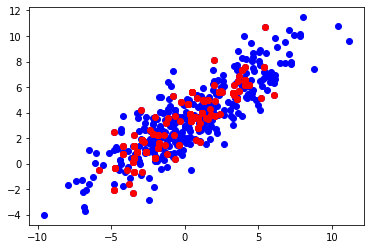

  0%|          | 0/1 [00:00<?, ?it/s]

Expected sample size 4.47 at iteration 0. (99% probability sample size is >0.0)


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Expected sample size 8.45 at iteration 1. (99% probability sample size is >3.0)


100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


Expected sample size 38.71 at iteration 2. (99% probability sample size is >25.0)


100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


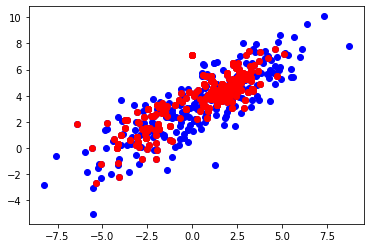

Expected sample size 90.05 at iteration 3. (99% probability sample size is >69.0)


100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


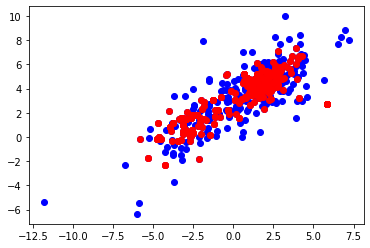

Expected sample size 102.47 at iteration 4. (99% probability sample size is >80.0)


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


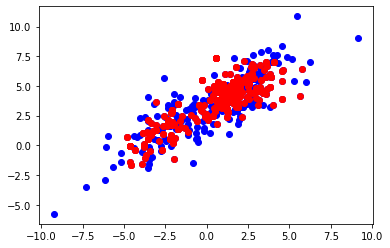

Expected sample size 209.44 at iteration 5. (99% probability sample size is >178.0)


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


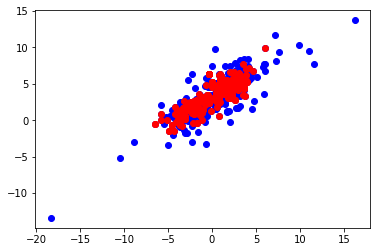

Expected sample size 251.2 at iteration 6. (99% probability sample size is >217.0)


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


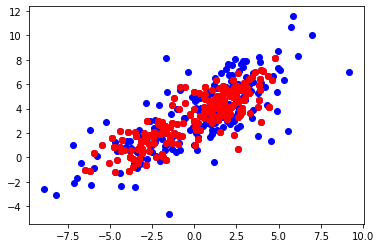

Expected sample size 248.99 at iteration 7. (99% probability sample size is >214.0)


100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


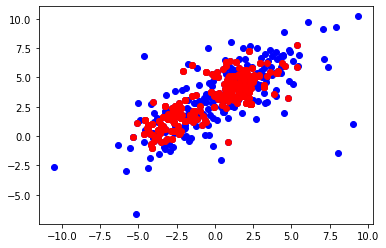

Expected sample size 417.28 at iteration 8. (99% probability sample size is >373.0)


100%|██████████| 9/9 [00:16<00:00,  1.79s/it]


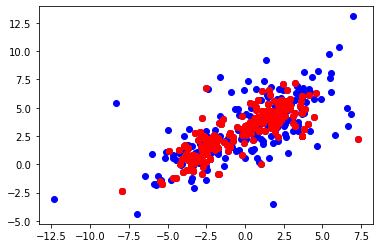

Expected sample size 281.06 at iteration 9. (99% probability sample size is >244.0)


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


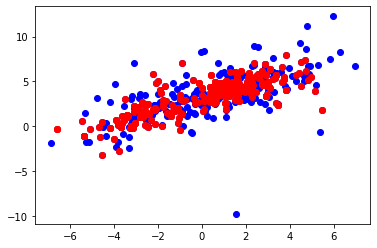

Expected sample size 389.27 at iteration 10. (99% probability sample size is >346.0)


100%|██████████| 11/11 [00:26<00:00,  2.43s/it]


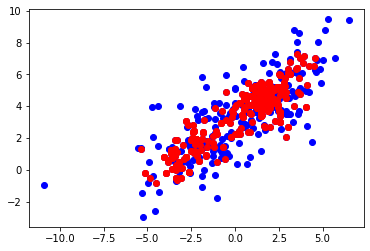

Expected sample size 672.36 at iteration 11. (99% probability sample size is >617.0)
----------------------------------------------------------------------------------
			Sampling chain 2
----------------------------------------------------------------------------------


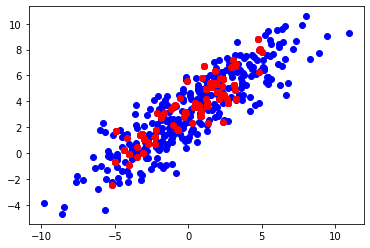

  0%|          | 0/1 [00:00<?, ?it/s]

Expected sample size 4.19 at iteration 0. (99% probability sample size is >0.0)


100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


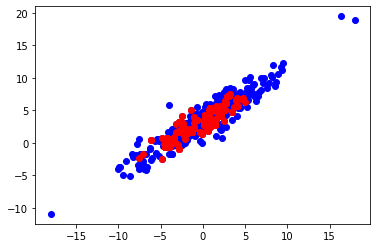

  0%|          | 0/2 [00:00<?, ?it/s]

Expected sample size 16.06 at iteration 1. (99% probability sample size is >8.0)


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


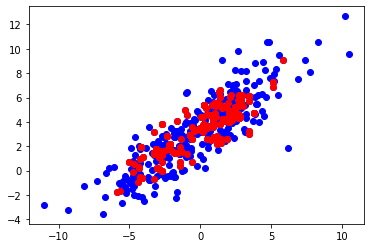

Expected sample size 31.51 at iteration 2. (99% probability sample size is >19.0)


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


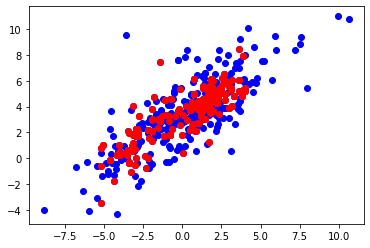

Expected sample size 30.53 at iteration 3. (99% probability sample size is >19.0)


100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


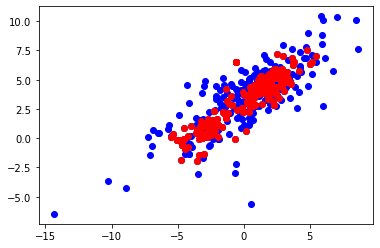

Expected sample size 87.44 at iteration 4. (99% probability sample size is >67.0)


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


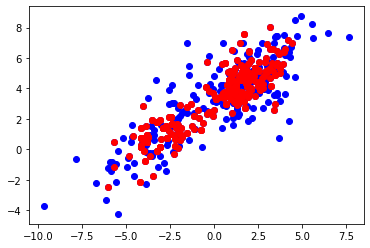

Expected sample size 175.07 at iteration 5. (99% probability sample size is >146.0)


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


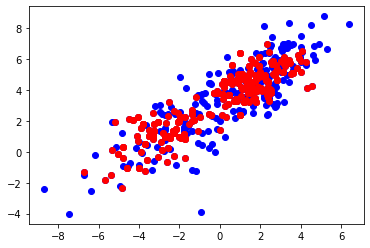

Expected sample size 158.08 at iteration 6. (99% probability sample size is >130.0)


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


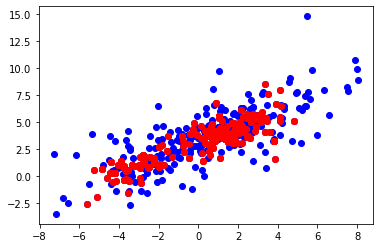

Expected sample size 132.74 at iteration 7. (99% probability sample size is >107.0)


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


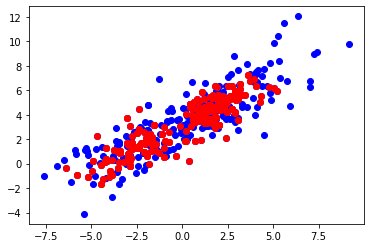

Expected sample size 349.27 at iteration 8. (99% probability sample size is >309.0)


100%|██████████| 9/9 [00:15<00:00,  1.70s/it]


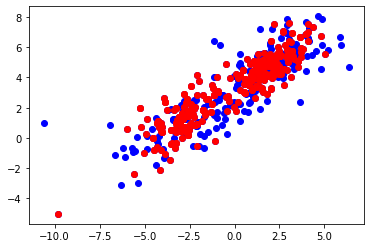

Expected sample size 355.33 at iteration 9. (99% probability sample size is >314.0)


100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


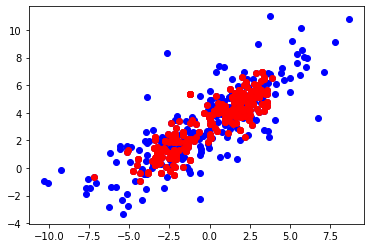

Expected sample size 380.08 at iteration 10. (99% probability sample size is >337.0)


100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


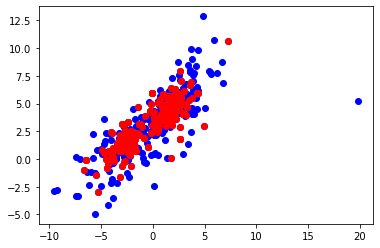

Expected sample size 546.11 at iteration 11. (99% probability sample size is >496.0)


In [ ]:
pmc=PMC(target=GMM,proposal=proposal, use_pareto_smoothing=True)
sample=pmc.sample(target_size=400, samples_per_iteration=400, show_plots=True)

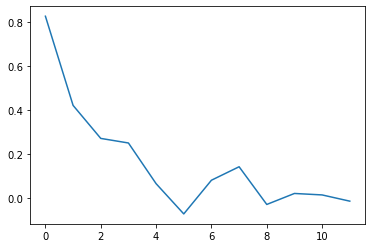

In [ ]:
pyplot.plot(pmc.pmc_chains[1].trackers.pareto_k)

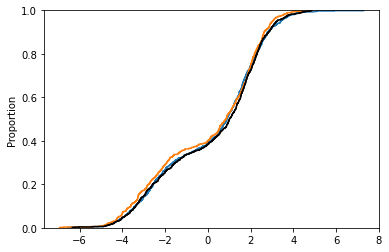

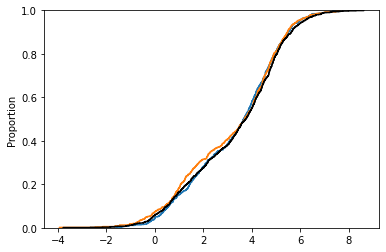

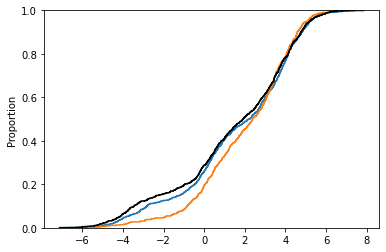

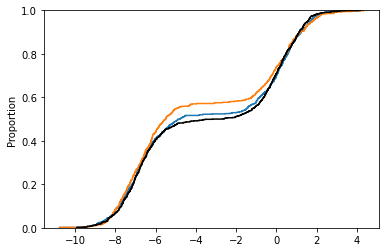

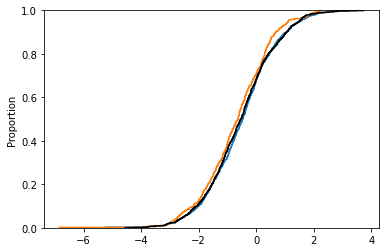

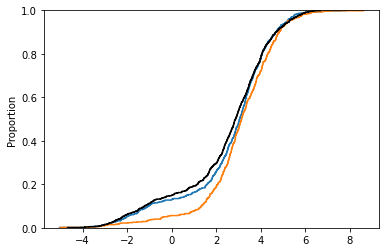

In [ ]:
for i in range(6):
    seaborn.ecdfplot(sample[0][:,i])
    seaborn.ecdfplot(sample[1][:,i])
    seaborn.ecdfplot(X[:,i], c='black')
    
    pyplot.show()

----------------------------------------------------------------------------------
			Sampling chain 1
----------------------------------------------------------------------------------


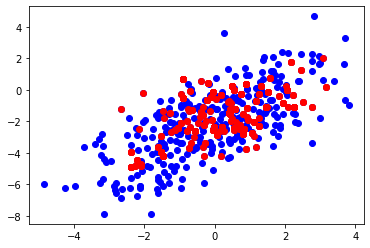

  0%|          | 0/1 [00:00<?, ?it/s]

Expected sample size 17.12 at iteration 0. (99% probability sample size is >8.0)


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


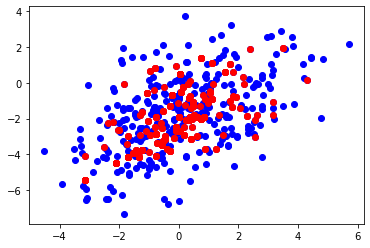

  0%|          | 0/2 [00:00<?, ?it/s]

Expected sample size 39.85 at iteration 1. (99% probability sample size is >26.0)


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


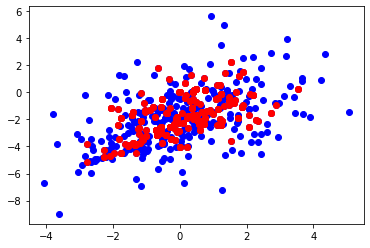

Expected sample size 63.51 at iteration 2. (99% probability sample size is >46.0)


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


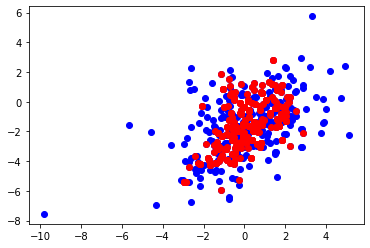

Expected sample size 64.22 at iteration 3. (99% probability sample size is >47.0)


100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


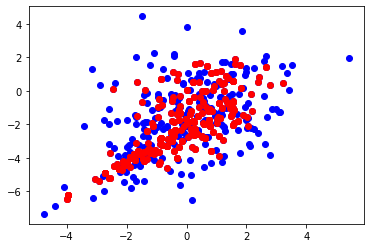

Expected sample size 103.59 at iteration 4. (99% probability sample size is >81.0)


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


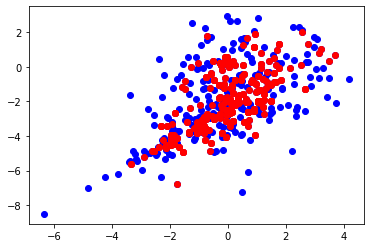

Expected sample size 256.7 at iteration 5. (99% probability sample size is >222.0)


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


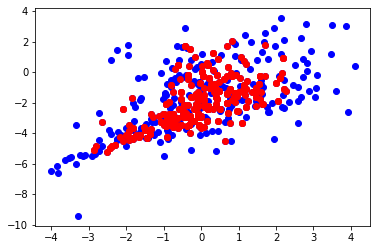

Expected sample size 341.46 at iteration 6. (99% probability sample size is >302.0)


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


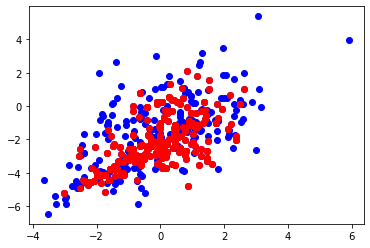

Expected sample size 355.99 at iteration 7. (99% probability sample size is >315.0)


100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


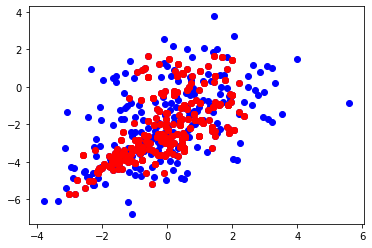

Expected sample size 308.88 at iteration 8. (99% probability sample size is >270.0)


100%|██████████| 9/9 [00:15<00:00,  1.78s/it]


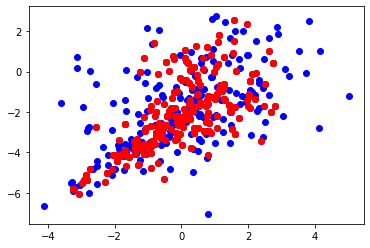

Expected sample size 450.59 at iteration 9. (99% probability sample size is >405.0)
----------------------------------------------------------------------------------
			Sampling chain 2
----------------------------------------------------------------------------------


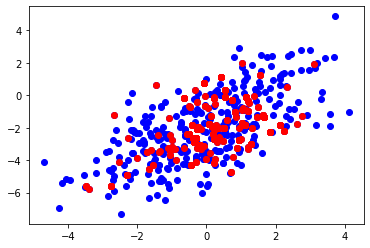

  0%|          | 0/1 [00:00<?, ?it/s]

Expected sample size 13.63 at iteration 0. (99% probability sample size is >6.0)


100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


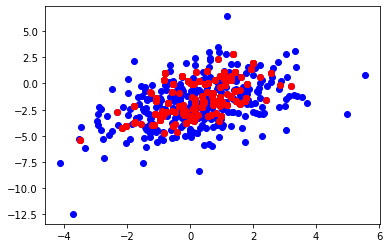

  0%|          | 0/2 [00:00<?, ?it/s]

Expected sample size 27.91 at iteration 1. (99% probability sample size is >17.0)


100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


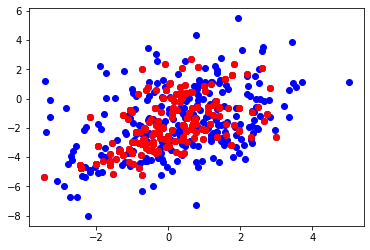

Expected sample size 51.79 at iteration 2. (99% probability sample size is >36.0)


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


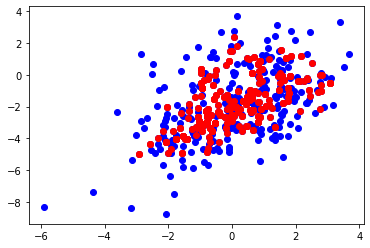

Expected sample size 44.74 at iteration 3. (99% probability sample size is >30.0)


100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


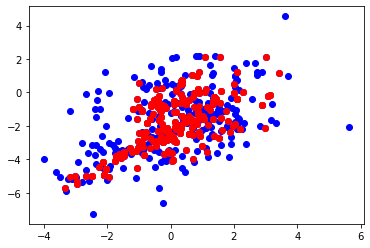

Expected sample size 71.29 at iteration 4. (99% probability sample size is >53.0)


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


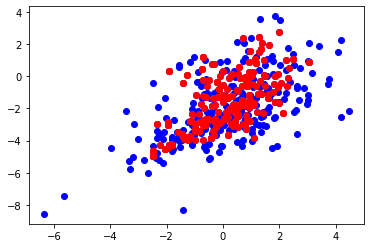

Expected sample size 41.38 at iteration 5. (99% probability sample size is >27.0)


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


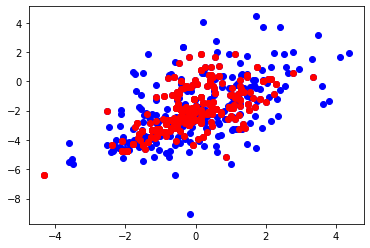

Expected sample size 182.07 at iteration 6. (99% probability sample size is >152.0)


100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


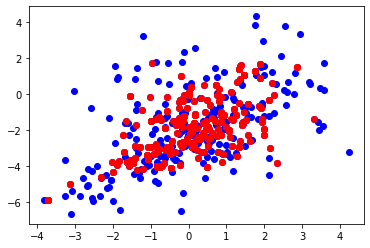

Expected sample size 111.25 at iteration 7. (99% probability sample size is >88.0)


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


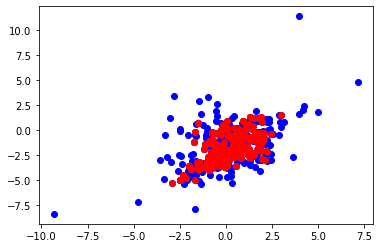

Expected sample size 298.75 at iteration 8. (99% probability sample size is >261.0)


100%|██████████| 9/9 [00:14<00:00,  1.63s/it]


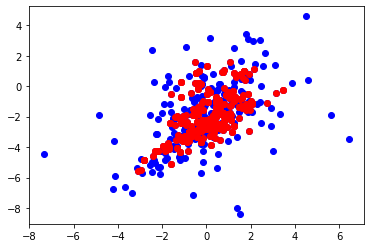

Expected sample size 286.86 at iteration 9. (99% probability sample size is >250.0)


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


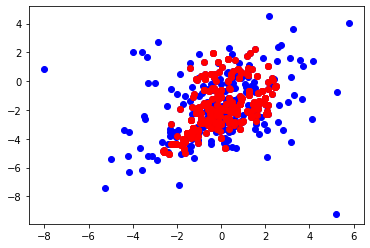

Expected sample size 544.16 at iteration 10. (99% probability sample size is >494.0)


In [ ]:
pmc=PMC(target=GMM,proposal=proposal, use_pareto_smoothing=False)
sample=pmc.sample(target_size=400, samples_per_iteration=400, show_plots=True)

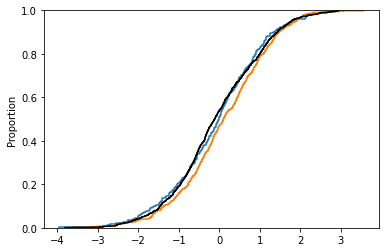

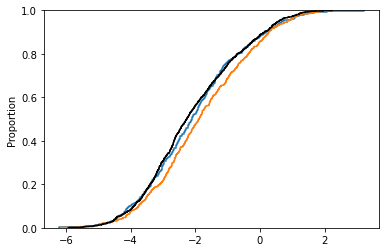

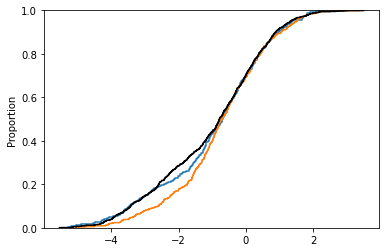

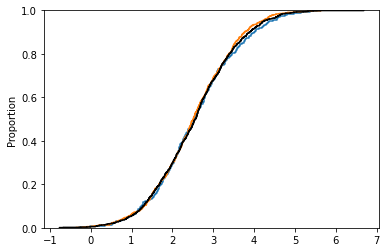

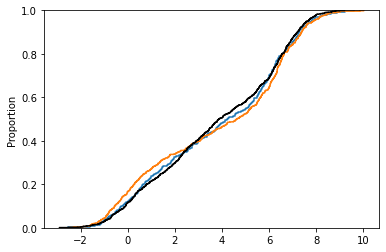

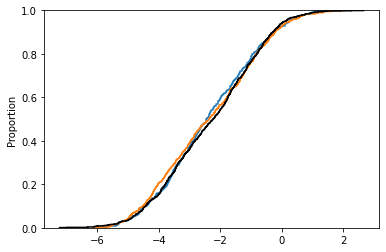

In [ ]:
for i in range(6):
    seaborn.ecdfplot(sample[0][:,i])
    seaborn.ecdfplot(sample[1][:,i])
    seaborn.ecdfplot(X[:,i], c='black')
    
    pyplot.show()